In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and automl libraries!')

Imported sci-kit learn and automl libraries!


# Irish Data - ML approach attempt 2
After our initial run of experiments I felt I needed to clean and process our Irish housing data more for better results. With our best performing algorithms returning only 17.5% accurate test predictions I tried to do more with the addresses provided. I extracted "neighbourhoods" from the addresses provided to focus in on an even smaller area than before and give more focused predictions in the hope of better results all around.

In [2]:
# new file containing rows with neighbourhoods occurring more than once
# this is to 1) cut out typos and 2) improve performance of our model.
# we still have ~250k rows to work with here
irl = pd.read_csv('more-than1-neigh.csv', index_col='Unnamed: 0')

In [3]:
irl

,Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate
0,"5 Braemor Drive, Churchtown",NaN,Dublin,343000.0,1,1,1,0,2010,1,Churchtown Dublin,Dublin,0,Braemor Drive Churchtown Dublin,Leinster,Estate
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,185000.0,1,0,0,1,2010,1,Portlaoise,Midlands,0,Summerhill Lane Portlaoise,Leinster,Estate
3,"1 The Haven, Mornington",NaN,Meath,400000.0,1,1,1,1,2010,1,Mornington,Mid-East,0,The Haven Mornington,Leinster,Estate
4,"12 Sallymount Avenue, Ranelagh",NaN,Dublin,425000.0,1,1,1,1,2010,1,Ranelagh,Dublin,0,Sallymount Avenue Ranelagh,Leinster,Estate
5,"15 Carriglawn, Waterpark, Carrigaline",NaN,Cork,180000.0,1,1,1,1,2010,1,Carrigaline,South-West (IE),0,Waterpark Carrigaline,Munster,Estate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299498,"Ballinkillin, Bagenalstown, Carlow",NaN,Carlow,175000.0,1,1,1,1,2017,6,Muine Bheag,South East (IE),0,Ballinkillin Muine Bheag,Leinster,Other
299499,"Donore, Bagenalstown, Co. Carlow",NaN,Carlow,148000.0,1,1,1,1,2013,4,Muine Bheag,South East (IE),0,Donore Muine Bheag,Leinster,Other
299501,"Loughlinstown, Rathoath, Co Meath",NaN,Meath,610000.0,1,0,0,2,2013,5,Ratoath,Mid-East,0,Loughlinstown Ratoath,Leinster,Other
299502,"5 Streamstown, Rathoath, Co Meath",NaN,Meath,380000.0,1,1,1,1,2017,12,Ratoath,Mid-East,0,Streamstown Ratoath,Leinster,Estate


In [4]:
irl['Apartment'] = irl['Apartment'].fillna(0.0)

In [5]:
irl.head()

,Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate
0,"5 Braemor Drive, Churchtown",NaN,Dublin,343000.0,1,1,1,0,2010,1,Churchtown Dublin,Dublin,0,Braemor Drive Churchtown Dublin,Leinster,Estate
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,185000.0,1,0,0,1,2010,1,Portlaoise,Midlands,0,Summerhill Lane Portlaoise,Leinster,Estate
3,"1 The Haven, Mornington",NaN,Meath,400000.0,1,1,1,1,2010,1,Mornington,Mid-East,0,The Haven Mornington,Leinster,Estate
4,"12 Sallymount Avenue, Ranelagh",NaN,Dublin,425000.0,1,1,1,1,2010,1,Ranelagh,Dublin,0,Sallymount Avenue Ranelagh,Leinster,Estate
5,"15 Carriglawn, Waterpark, Carrigaline",NaN,Cork,180000.0,1,1,1,1,2010,1,Carrigaline,South-West (IE),0,Waterpark Carrigaline,Munster,Estate


In [6]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [7]:
irl.drop(columns=['Postal Code'], inplace=True)
irl

,Address,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate
0,"5 Braemor Drive, Churchtown",Dublin,343000.0,1,1,1,0,2010,1,Churchtown Dublin,Dublin,0,Braemor Drive Churchtown Dublin,Leinster,Estate
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,185000.0,1,0,0,1,2010,1,Portlaoise,Midlands,0,Summerhill Lane Portlaoise,Leinster,Estate
3,"1 The Haven, Mornington",Meath,400000.0,1,1,1,1,2010,1,Mornington,Mid-East,0,The Haven Mornington,Leinster,Estate
4,"12 Sallymount Avenue, Ranelagh",Dublin,425000.0,1,1,1,1,2010,1,Ranelagh,Dublin,0,Sallymount Avenue Ranelagh,Leinster,Estate
5,"15 Carriglawn, Waterpark, Carrigaline",Cork,180000.0,1,1,1,1,2010,1,Carrigaline,South-West (IE),0,Waterpark Carrigaline,Munster,Estate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299498,"Ballinkillin, Bagenalstown, Carlow",Carlow,175000.0,1,1,1,1,2017,6,Muine Bheag,South East (IE),0,Ballinkillin Muine Bheag,Leinster,Other
299499,"Donore, Bagenalstown, Co. Carlow",Carlow,148000.0,1,1,1,1,2013,4,Muine Bheag,South East (IE),0,Donore Muine Bheag,Leinster,Other
299501,"Loughlinstown, Rathoath, Co Meath",Meath,610000.0,1,0,0,2,2013,5,Ratoath,Mid-East,0,Loughlinstown Ratoath,Leinster,Other
299502,"5 Streamstown, Rathoath, Co Meath",Meath,380000.0,1,1,1,1,2017,12,Ratoath,Mid-East,0,Streamstown Ratoath,Leinster,Estate


In [8]:
encoder = TargetEncoder()
irl['Town'] = encoder.fit_transform(irl['Town'], irl['Price (€)'])

In [9]:
encoder = TargetEncoder()
irl['Region'] = encoder.fit_transform(irl['Region'], irl['Price (€)'])

In [10]:
encoder = TargetEncoder()
irl['County'] = encoder.fit_transform(irl['County'], irl['Price (€)'])

In [11]:
irl

,Address,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate
0,"5 Braemor Drive, Churchtown",363311.258541,343000.0,1,1,1,0,2010,1,420564.880451,363311.258541,0,Braemor Drive Churchtown Dublin,Leinster,Estate
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",143914.074354,185000.0,1,0,0,1,2010,1,146388.228701,137812.536269,0,Summerhill Lane Portlaoise,Leinster,Estate
3,"1 The Haven, Mornington",236417.551281,400000.0,1,1,1,1,2010,1,247327.006696,263772.291871,0,The Haven Mornington,Leinster,Estate
4,"12 Sallymount Avenue, Ranelagh",363311.258541,425000.0,1,1,1,1,2010,1,534155.362869,363311.258541,0,Sallymount Avenue Ranelagh,Leinster,Estate
5,"15 Carriglawn, Waterpark, Carrigaline",215160.369898,180000.0,1,1,1,1,2010,1,255371.680067,203336.657684,0,Waterpark Carrigaline,Munster,Estate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299498,"Ballinkillin, Bagenalstown, Carlow",150924.669445,175000.0,1,1,1,1,2017,6,135253.171193,152847.484716,0,Ballinkillin Muine Bheag,Leinster,Other
299499,"Donore, Bagenalstown, Co. Carlow",150924.669445,148000.0,1,1,1,1,2013,4,135253.171193,152847.484716,0,Donore Muine Bheag,Leinster,Other
299501,"Loughlinstown, Rathoath, Co Meath",236417.551281,610000.0,1,0,0,2,2013,5,311968.768420,263772.291871,0,Loughlinstown Ratoath,Leinster,Other
299502,"5 Streamstown, Rathoath, Co Meath",236417.551281,380000.0,1,1,1,1,2017,12,311968.768420,263772.291871,0,Streamstown Ratoath,Leinster,Estate


In [12]:
encoder = TargetEncoder()
irl['Neighbourhood'] = encoder.fit_transform(irl['Neighbourhood'], irl['Price (€)'])

In [13]:
cleanup_nums_new = {"Estate": {"Other": 0, "Estate": 1}}
irl = irl.replace(cleanup_nums_new)
irl.head()

,Address,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate
0,"5 Braemor Drive, Churchtown",363311.258541,343000.0,1,1,1,0,2010,1,420564.880451,363311.258541,0,419389.799500,Leinster,1
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",143914.074354,185000.0,1,0,0,1,2010,1,146388.228701,137812.536269,0,198970.065714,Leinster,1
3,"1 The Haven, Mornington",236417.551281,400000.0,1,1,1,1,2010,1,247327.006696,263772.291871,0,288274.989445,Leinster,1
4,"12 Sallymount Avenue, Ranelagh",363311.258541,425000.0,1,1,1,1,2010,1,534155.362869,363311.258541,0,521096.081067,Leinster,1
5,"15 Carriglawn, Waterpark, Carrigaline",215160.369898,180000.0,1,1,1,1,2010,1,255371.680067,203336.657684,0,203525.216226,Munster,1


In [14]:
irl

,Address,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate
0,"5 Braemor Drive, Churchtown",363311.258541,343000.0,1,1,1,0,2010,1,420564.880451,363311.258541,0,419389.799500,Leinster,1
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",143914.074354,185000.0,1,0,0,1,2010,1,146388.228701,137812.536269,0,198970.065714,Leinster,1
3,"1 The Haven, Mornington",236417.551281,400000.0,1,1,1,1,2010,1,247327.006696,263772.291871,0,288274.989445,Leinster,1
4,"12 Sallymount Avenue, Ranelagh",363311.258541,425000.0,1,1,1,1,2010,1,534155.362869,363311.258541,0,521096.081067,Leinster,1
5,"15 Carriglawn, Waterpark, Carrigaline",215160.369898,180000.0,1,1,1,1,2010,1,255371.680067,203336.657684,0,203525.216226,Munster,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299498,"Ballinkillin, Bagenalstown, Carlow",150924.669445,175000.0,1,1,1,1,2017,6,135253.171193,152847.484716,0,171745.625646,Leinster,0
299499,"Donore, Bagenalstown, Co. Carlow",150924.669445,148000.0,1,1,1,1,2013,4,135253.171193,152847.484716,0,191849.736559,Leinster,0
299501,"Loughlinstown, Rathoath, Co Meath",236417.551281,610000.0,1,0,0,2,2013,5,311968.768420,263772.291871,0,449252.399406,Leinster,0
299502,"5 Streamstown, Rathoath, Co Meath",236417.551281,380000.0,1,1,1,1,2017,12,311968.768420,263772.291871,0,351232.540690,Leinster,1


In [15]:
irl.drop(columns=['Address', 'Province', 'Estate'], inplace=True)

In [16]:
irl

,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood
0,363311.258541,343000.0,1,1,1,0,2010,1,420564.880451,363311.258541,0,419389.799500
1,143914.074354,185000.0,1,0,0,1,2010,1,146388.228701,137812.536269,0,198970.065714
3,236417.551281,400000.0,1,1,1,1,2010,1,247327.006696,263772.291871,0,288274.989445
4,363311.258541,425000.0,1,1,1,1,2010,1,534155.362869,363311.258541,0,521096.081067
5,215160.369898,180000.0,1,1,1,1,2010,1,255371.680067,203336.657684,0,203525.216226
...,...,...,...,...,...,...,...,...,...,...,...,...
299498,150924.669445,175000.0,1,1,1,1,2017,6,135253.171193,152847.484716,0,171745.625646
299499,150924.669445,148000.0,1,1,1,1,2013,4,135253.171193,152847.484716,0,191849.736559
299501,236417.551281,610000.0,1,0,0,2,2013,5,311968.768420,263772.291871,0,449252.399406
299502,236417.551281,380000.0,1,1,1,1,2017,12,311968.768420,263772.291871,0,351232.540690


In [17]:
irl['LogPrice (€)'] = np.log(irl['Price (€)'])

In [18]:
irl.drop(columns=['Price (€)', 'Description of Property'], inplace = True)

In [19]:
irl.head()

,County,Not Full Market Price,VAT Exclusive,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,LogPrice (€)
0,363311.258541,1,1,0,2010,1,420564.880451,363311.258541,0,419389.799500,12.745486
1,143914.074354,1,0,1,2010,1,146388.228701,137812.536269,0,198970.065714,12.128111
3,236417.551281,1,1,1,2010,1,247327.006696,263772.291871,0,288274.989445,12.899220
4,363311.258541,1,1,1,2010,1,534155.362869,363311.258541,0,521096.081067,12.959844
5,215160.369898,1,1,1,2010,1,255371.680067,203336.657684,0,203525.216226,12.100712


In [20]:
x = irl.loc[:, irl.columns != 'LogPrice (€)']
y = irl['LogPrice (€)']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(X_train, y_train)

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.760581 trained in 0.53 seconds
2_DecisionTree rmse 0.463468 trained in 18.76 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.403257 trained in 42.6 seconds
4_Default_NeuralNetwork rmse 0.41648 trained in 18.05 seconds
5_Default_RandomForest rmse 0.437346 trained in 23.27 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.403257 trained in 0.55 seconds
AutoML fit time: 119.76 seconds
AutoML best model: 3_Default_Xgboost


AutoML(total_time_limit=300)

In [22]:
# calculated values
y_predicted = automl.predict(X_test)
  
# Calculation of Mean Squared Error (MSE)
mean_squared_error(y_test, y_predicted)

0.1595677256014736

In [23]:
accuracy_threshold(y_test, y_predicted, 0.1)

0.3002298973481608

In [24]:
median_se = np.square(np.subtract(y_test, y_predicted)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.18510899744526302


### Let's try predict a specific years values given some historical data
We will look at using 3 years worth of data and use it to predict some data for a selected year, let's say 2021, now.

In [25]:
specific21 = irl[irl['Year'] > 2017]

A regular train to test split will not suffice here as we need only the years 2018, 2019 and 2020 in our training data, while only using the houses associated with 2021 in our test data.

In [26]:
specific21[specific21['Year'] == 2021]

,County,Not Full Market Price,VAT Exclusive,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,LogPrice (€)
152655,215160.369898,1,0,2,2021,1,147427.309669,203336.657684,0,174420.017636,11.974079
152656,363311.258541,1,0,2,2021,1,136600.824751,363311.258541,0,193626.533333,12.170192
152657,163525.267347,1,1,2,2021,1,125623.181410,155565.894684,0,197072.910803,11.695247
152658,236417.551281,1,1,2,2021,1,227753.682745,263772.291871,0,270195.598590,12.796633
152660,236417.551281,1,1,2,2021,1,264944.031465,263772.291871,0,404540.203738,13.190022
...,...,...,...,...,...,...,...,...,...,...,...
299462,154744.301827,0,0,2,2021,6,136577.926622,152847.484716,0,195253.693125,11.896118
299463,154744.301827,0,0,2,2021,6,136577.926622,152847.484716,0,195253.693125,11.896118
299464,154744.301827,0,0,2,2021,6,136577.926622,152847.484716,0,195253.693125,11.896118
299465,154744.301827,0,0,2,2021,6,136577.926622,152847.484716,0,195253.693125,11.896118


In [27]:
specific21.shape[0]

94648

In [28]:
train_21 = specific21[specific21['Year'] < 2021]

In [29]:
#train_21 = train_21.sample(n = 80000)
train_21

,County,Not Full Market Price,VAT Exclusive,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,LogPrice (€)
108817,363311.258541,1,1,2,2018,1,373904.180835,363311.258541,0,355065.390599,13.349070
108818,311830.754461,1,0,2,2018,1,324653.104870,263772.291871,0,385664.353896,13.208541
108819,136238.546858,1,1,2,2018,1,151084.791077,152847.484716,0,170766.761682,11.918391
108820,148534.124012,1,1,2,2018,1,155445.085356,137812.536269,0,137270.000471,11.982929
108822,363311.258541,1,1,1,2018,1,322101.887699,363311.258541,0,400695.449020,12.760008
...,...,...,...,...,...,...,...,...,...,...,...
299489,99476.854767,1,1,1,2020,3,107066.663731,136425.390561,1,100227.100092,11.456355
299492,99476.854767,1,1,1,2018,7,107066.663731,136425.390561,0,100227.100092,12.230765
299493,99476.854767,1,1,1,2018,7,107066.663731,136425.390561,0,119567.093083,11.736069
299494,99476.854767,1,1,2,2018,7,107066.663731,136425.390561,0,105116.457428,12.106252


In [30]:
test_21 = specific21[specific21['Year'] == 2021]

In [31]:
x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

In [32]:
#test_21 = test_21.sample(n = 15000)
test_21

,County,Not Full Market Price,VAT Exclusive,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,LogPrice (€)
152655,215160.369898,1,0,2,2021,1,147427.309669,203336.657684,0,174420.017636,11.974079
152656,363311.258541,1,0,2,2021,1,136600.824751,363311.258541,0,193626.533333,12.170192
152657,163525.267347,1,1,2,2021,1,125623.181410,155565.894684,0,197072.910803,11.695247
152658,236417.551281,1,1,2,2021,1,227753.682745,263772.291871,0,270195.598590,12.796633
152660,236417.551281,1,1,2,2021,1,264944.031465,263772.291871,0,404540.203738,13.190022
...,...,...,...,...,...,...,...,...,...,...,...
299462,154744.301827,0,0,2,2021,6,136577.926622,152847.484716,0,195253.693125,11.896118
299463,154744.301827,0,0,2,2021,6,136577.926622,152847.484716,0,195253.693125,11.896118
299464,154744.301827,0,0,2,2021,6,136577.926622,152847.484716,0,195253.693125,11.896118
299465,154744.301827,0,0,2,2021,6,136577.926622,152847.484716,0,195253.693125,11.896118


In [33]:
x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

In [34]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_21, y_train_21)

Linear algorithm was disabled.
AutoML directory: AutoML_2
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.691928 trained in 0.72 seconds
2_DecisionTree rmse 0.411014 trained in 5.09 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.378644 trained in 13.73 seconds
4_Default_NeuralNetwork rmse 0.386331 trained in 7.9 seconds
5_Default_RandomForest rmse 0.396726 trained in 9.46 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.37836 trained in 0.37 seconds
AutoML fit time: 50.91 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [35]:
# calculated values
y_predicted_21 = automl.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_predicted_21)
print('MSE for AutoML 2021 is: ' + str(mse))

MSE for AutoML 2021 is: 0.15213316194034535


In [36]:
rmse = mean_squared_error(y_test_21, y_predicted_21, squared=False)
print('RMSE for AutoML 2021 is: ' + str(rmse))

RMSE for AutoML 2021 is: 0.390042512991014


In [37]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.29122701236056675


In [38]:
median_se = np.square(np.subtract(y_test_21, y_predicted_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1907541977489089


In [39]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_21, y_predicted_21)
print("MAPE for AutoML 2021 is: " + str(mape))

MAPE for AutoML 2021 is: 0.022514337715153272


In [40]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

### It seems our results are even more accurate when selecting a specific year to predict
It is interesting to note here our RMSE values are equal between XgBoost and Ensemble models. The results here across all our evaluation metrics are very strong it has to be said. We will now test 2020 and a couple of more years to robustly test our yearly predictions.

### 2020 predictions

In [41]:
specific20 = irl[irl['Year'] > 2016]

In [42]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

In [43]:
#train_20 = train_20.sample(n = 75000)

In [44]:
x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

In [45]:
#test_20 = test_20.sample(n = 15000)

In [46]:
x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

In [47]:
automl = AutoML(total_time_limit=5*60)
automl.fit(x_train_20, y_train_20)

Linear algorithm was disabled.
AutoML directory: AutoML_3
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.718204 trained in 0.8 seconds
2_DecisionTree rmse 0.419661 trained in 6.41 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.383675 trained in 16.4 seconds
4_Default_NeuralNetwork rmse 0.394864 trained in 8.53 seconds
5_Default_RandomForest rmse 0.405072 trained in 12.13 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.383558 trained in 0.5 seconds
AutoML fit time: 59.35 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [48]:
# calculated values
y_predicted_20 = automl.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_predicted_20)
print('MSE for AutoML 2020 is: ' + str(mse))

MSE for AutoML 2020 is: 0.146243491734016


In [49]:
rmse = mean_squared_error(y_test_20,y_predicted_20, squared=False)
print('RMSE for AutoML 2020 is: ' + str(rmse))

RMSE for AutoML 2020 is: 0.3824179542516486


In [50]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3353288141561757


In [51]:
print("Median Absolute Error:\n")
print(median_absolute_error(y_test_20,y_predicted_20))

Median Absolute Error:

0.16529681377761563


In [52]:
mape = mean_absolute_percentage_error(y_test_20, y_predicted_20)
print("MAPE for AutoML 2020 is: " + str(mape))

MAPE for AutoML 2020 is: 0.021233323715305178


In [53]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df10 = pd.DataFrame(columns=cnames)

df10 = df10.append({'Algorithm': 'AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape
          }, ignore_index=True)

### Multiple Linear Regression

Next, I will try implement some algorithms not specified in our autoML library which so far has only utilised XgBoost, Random Forest, Decison Tree and ensemble algorithms. I will attempt to implement other ML algorithms such as multiple linear regression and adaboost among others.

There is a couple of different libraries we can use here for linear regression:
- Sci-kit learn's linear model library
- Statsmodel

For the purpose of this I will remain consistent with the use of the sci-kit learn libraries.

In [54]:
from sklearn import linear_model

#### Let's try predict our 2021 values again using MLR

In [55]:
lm = linear_model.LinearRegression()
lm.fit(x_train_21, y_train_21) # fitting the model

LinearRegression()

In [56]:
y_pred_21 = lm.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for MLR 2021 is: ' + str(mse))

MSE for MLR 2021 is: 0.1937942128885875


In [57]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.247090744648779


In [58]:
median_se = np.square(np.subtract(y_test_21,y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.22593337564414284


In [59]:
mean = np.square(np.subtract(y_test_21,y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.4402206411432647


In [60]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.02570659220396112


In [61]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df9 = pd.DataFrame(columns=cnames)

df9 = df9.append({'Algorithm': 'MLR',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2020 predictions

In [62]:
lm = linear_model.LinearRegression()
lm.fit(x_train_20, y_train_20) # fitting the model

LinearRegression()

In [63]:
y_pred_20 = lm.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_pred_20)
print('MSE for MLR 2020 is: ' + str(mse))

MSE for MLR 2020 is: 0.18930670257044405


In [64]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2723391143586583


In [65]:
median_se = np.square(np.subtract(y_test_20,y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.19958348811527937


In [66]:
mean = np.square(np.subtract(y_test_20,y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.43509390086559857


In [68]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for MLR 2020 is: " + str(mape))

MAPE for MLR 2020 is: 0.024719969837441055


In [69]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df8 = pd.DataFrame(columns=cnames)

df8 = df8.append({'Algorithm': 'MLR',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Adaboost

#### 2021 Predictions

In [70]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

In [71]:
model = AdaBoostRegressor()

In [72]:
model.fit(x_train_21, y_train_21)

AdaBoostRegressor()

In [73]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for AdaBoost 2021 is: ' + str(mse))

MSE for AdaBoost 2021 is: 0.35566812496756794


In [74]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.14525173349412118


In [75]:
median_se = np.square(np.subtract(y_test_21,y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.40984528113861174


In [76]:
mean = np.square(np.subtract(y_test_21,y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.5963791788514778


In [77]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for AdaBoost 2021 is: " + str(mape))

MAPE for AdaBoost 2021 is: 0.03849297460279107


In [78]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df7 = pd.DataFrame(columns=cnames)

df7 = df7.append({'Algorithm': 'AdaBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020 Predictions

In [79]:
model = AdaBoostRegressor()
model.fit(x_train_20, y_train_20)

AdaBoostRegressor()

In [80]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_pred_20)
print('MSE for AdaBoost 2020 is: ' + str(mse))

MSE for AdaBoost 2020 is: 0.35659957307502294


In [81]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.14147372127828153


In [82]:
median_se = np.square(np.subtract(y_test_20,y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.4187774702259226


In [83]:
mean = np.square(np.subtract(y_test_20,y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.597159587610398


In [84]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for AdaBoost 2020 is: " + str(mape))

MAPE for AdaBoost 2020 is: 0.0390215620916572


In [85]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df6 = pd.DataFrame(columns=cnames)

df6 = df6.append({'Algorithm': 'AdaBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

## Let's now try a selection of other algorithms on our data
### LightGBM

In [86]:
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

### 2020 House Price Prediction Using LightGBM

In [87]:
model = LGBMRegressor()
model.fit(x_train_20, y_train_20)

LGBMRegressor()

In [88]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_pred_20)
print('MSE for LightGBM 2020 is: ' + str(mse))

MSE for LightGBM 2020 is: 0.14370157314457976


In [89]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3341843472136632


In [90]:
median_se = np.square(np.subtract(y_test_20,y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1651315876258991


In [91]:
mean = np.square(np.subtract(y_test_20,y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.3790799033773474


In [92]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for LightGBM 2020 is: " + str(mape))

MAPE for LightGBM 2020 is: 0.021102966375760285


In [93]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df5 = pd.DataFrame(columns=cnames)

df5 = df5.append({'Algorithm': 'LightGBM',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2021

In [94]:
model = LGBMRegressor()
model.fit(x_train_21, y_train_21)

LGBMRegressor()

In [95]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for LightGBM 2021 is: ' + str(mse))

MSE for LightGBM 2021 is: 0.1508840550389194


In [96]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2968344889960808


In [97]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.18962119502176122


In [98]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.38843796807073283


In [99]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.022392917505173582


In [100]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df4 = pd.DataFrame(columns=cnames)

df4 = df4.append({'Algorithm': 'LightGBM',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### CatBoost

#### 2021 Prediction

In [101]:
from catboost import CatBoostRegressor

In [102]:
model = CatBoostRegressor()
model.fit(x_train_21, y_train_21)

Learning rate set to 0.081505
0:	learn: 0.6538812	total: 161ms	remaining: 2m 40s
1:	learn: 0.6228217	total: 175ms	remaining: 1m 27s
2:	learn: 0.5951719	total: 189ms	remaining: 1m 2s
3:	learn: 0.5704421	total: 203ms	remaining: 50.5s
4:	learn: 0.5482333	total: 217ms	remaining: 43.2s
5:	learn: 0.5284166	total: 230ms	remaining: 38.1s
6:	learn: 0.5108239	total: 243ms	remaining: 34.4s
7:	learn: 0.4952872	total: 256ms	remaining: 31.8s
8:	learn: 0.4822499	total: 270ms	remaining: 29.7s
9:	learn: 0.4703085	total: 283ms	remaining: 28s
10:	learn: 0.4596347	total: 296ms	remaining: 26.6s
11:	learn: 0.4503879	total: 312ms	remaining: 25.7s
12:	learn: 0.4422648	total: 329ms	remaining: 25s
13:	learn: 0.4350278	total: 346ms	remaining: 24.3s
14:	learn: 0.4287580	total: 362ms	remaining: 23.8s
15:	learn: 0.4232177	total: 377ms	remaining: 23.2s
16:	learn: 0.4188738	total: 394ms	remaining: 22.8s
17:	learn: 0.4147540	total: 407ms	remaining: 22.2s
18:	learn: 0.4110700	total: 420ms	remaining: 21.7s
19:	learn: 0.

166:	learn: 0.3758775	total: 3.43s	remaining: 17.1s
167:	learn: 0.3758438	total: 3.44s	remaining: 17.1s
168:	learn: 0.3758146	total: 3.46s	remaining: 17s
169:	learn: 0.3757829	total: 3.47s	remaining: 16.9s
170:	learn: 0.3757553	total: 3.48s	remaining: 16.9s
171:	learn: 0.3757134	total: 3.49s	remaining: 16.8s
172:	learn: 0.3756805	total: 3.5s	remaining: 16.7s
173:	learn: 0.3756392	total: 3.52s	remaining: 16.7s
174:	learn: 0.3756027	total: 3.53s	remaining: 16.6s
175:	learn: 0.3755519	total: 3.54s	remaining: 16.6s
176:	learn: 0.3755186	total: 3.56s	remaining: 16.5s
177:	learn: 0.3754765	total: 3.57s	remaining: 16.5s
178:	learn: 0.3754213	total: 3.58s	remaining: 16.4s
179:	learn: 0.3753733	total: 3.6s	remaining: 16.4s
180:	learn: 0.3753264	total: 3.61s	remaining: 16.3s
181:	learn: 0.3752877	total: 3.62s	remaining: 16.3s
182:	learn: 0.3752487	total: 3.63s	remaining: 16.2s
183:	learn: 0.3751957	total: 3.65s	remaining: 16.2s
184:	learn: 0.3751626	total: 3.66s	remaining: 16.1s
185:	learn: 0.37

326:	learn: 0.3709059	total: 5.59s	remaining: 11.5s
327:	learn: 0.3708592	total: 5.6s	remaining: 11.5s
328:	learn: 0.3708323	total: 5.62s	remaining: 11.5s
329:	learn: 0.3708103	total: 5.63s	remaining: 11.4s
330:	learn: 0.3707896	total: 5.64s	remaining: 11.4s
331:	learn: 0.3707564	total: 5.66s	remaining: 11.4s
332:	learn: 0.3707315	total: 5.67s	remaining: 11.4s
333:	learn: 0.3706997	total: 5.68s	remaining: 11.3s
334:	learn: 0.3706776	total: 5.7s	remaining: 11.3s
335:	learn: 0.3706509	total: 5.71s	remaining: 11.3s
336:	learn: 0.3706195	total: 5.72s	remaining: 11.3s
337:	learn: 0.3705975	total: 5.74s	remaining: 11.2s
338:	learn: 0.3705736	total: 5.75s	remaining: 11.2s
339:	learn: 0.3705542	total: 5.76s	remaining: 11.2s
340:	learn: 0.3705233	total: 5.77s	remaining: 11.2s
341:	learn: 0.3705072	total: 5.79s	remaining: 11.1s
342:	learn: 0.3704878	total: 5.8s	remaining: 11.1s
343:	learn: 0.3704628	total: 5.82s	remaining: 11.1s
344:	learn: 0.3704416	total: 5.83s	remaining: 11.1s
345:	learn: 0.3

497:	learn: 0.3666996	total: 7.62s	remaining: 7.68s
498:	learn: 0.3666777	total: 7.63s	remaining: 7.67s
499:	learn: 0.3666567	total: 7.65s	remaining: 7.65s
500:	learn: 0.3666219	total: 7.66s	remaining: 7.63s
501:	learn: 0.3665998	total: 7.68s	remaining: 7.62s
502:	learn: 0.3665876	total: 7.69s	remaining: 7.6s
503:	learn: 0.3665633	total: 7.7s	remaining: 7.58s
504:	learn: 0.3665407	total: 7.71s	remaining: 7.56s
505:	learn: 0.3665173	total: 7.72s	remaining: 7.54s
506:	learn: 0.3664749	total: 7.73s	remaining: 7.52s
507:	learn: 0.3664453	total: 7.74s	remaining: 7.5s
508:	learn: 0.3664253	total: 7.75s	remaining: 7.48s
509:	learn: 0.3664030	total: 7.76s	remaining: 7.46s
510:	learn: 0.3663739	total: 7.77s	remaining: 7.44s
511:	learn: 0.3663538	total: 7.78s	remaining: 7.42s
512:	learn: 0.3663324	total: 7.79s	remaining: 7.4s
513:	learn: 0.3663093	total: 7.81s	remaining: 7.38s
514:	learn: 0.3662799	total: 7.82s	remaining: 7.37s
515:	learn: 0.3662575	total: 7.83s	remaining: 7.35s
516:	learn: 0.36

658:	learn: 0.3631865	total: 10.3s	remaining: 5.32s
659:	learn: 0.3631601	total: 10.3s	remaining: 5.3s
660:	learn: 0.3631395	total: 10.3s	remaining: 5.28s
661:	learn: 0.3631126	total: 10.3s	remaining: 5.26s
662:	learn: 0.3630604	total: 10.3s	remaining: 5.25s
663:	learn: 0.3630413	total: 10.3s	remaining: 5.23s
664:	learn: 0.3630150	total: 10.3s	remaining: 5.21s
665:	learn: 0.3629909	total: 10.4s	remaining: 5.2s
666:	learn: 0.3629776	total: 10.4s	remaining: 5.18s
667:	learn: 0.3629546	total: 10.4s	remaining: 5.16s
668:	learn: 0.3629360	total: 10.4s	remaining: 5.14s
669:	learn: 0.3629122	total: 10.4s	remaining: 5.13s
670:	learn: 0.3628901	total: 10.4s	remaining: 5.11s
671:	learn: 0.3628832	total: 10.4s	remaining: 5.09s
672:	learn: 0.3628475	total: 10.4s	remaining: 5.07s
673:	learn: 0.3628179	total: 10.4s	remaining: 5.05s
674:	learn: 0.3627982	total: 10.5s	remaining: 5.04s
675:	learn: 0.3627780	total: 10.5s	remaining: 5.02s
676:	learn: 0.3627522	total: 10.5s	remaining: 5s
677:	learn: 0.362

828:	learn: 0.3599303	total: 12.4s	remaining: 2.56s
829:	learn: 0.3599132	total: 12.4s	remaining: 2.55s
830:	learn: 0.3598926	total: 12.4s	remaining: 2.53s
831:	learn: 0.3598772	total: 12.5s	remaining: 2.52s
832:	learn: 0.3598615	total: 12.5s	remaining: 2.5s
833:	learn: 0.3598487	total: 12.5s	remaining: 2.48s
834:	learn: 0.3598310	total: 12.5s	remaining: 2.47s
835:	learn: 0.3598053	total: 12.5s	remaining: 2.45s
836:	learn: 0.3597920	total: 12.5s	remaining: 2.44s
837:	learn: 0.3597813	total: 12.5s	remaining: 2.42s
838:	learn: 0.3597623	total: 12.6s	remaining: 2.41s
839:	learn: 0.3597488	total: 12.6s	remaining: 2.39s
840:	learn: 0.3597251	total: 12.6s	remaining: 2.38s
841:	learn: 0.3597060	total: 12.6s	remaining: 2.36s
842:	learn: 0.3596976	total: 12.6s	remaining: 2.35s
843:	learn: 0.3596778	total: 12.6s	remaining: 2.33s
844:	learn: 0.3596599	total: 12.6s	remaining: 2.32s
845:	learn: 0.3596450	total: 12.6s	remaining: 2.3s
846:	learn: 0.3596160	total: 12.7s	remaining: 2.29s
847:	learn: 0.

996:	learn: 0.3568915	total: 15.1s	remaining: 45.3ms
997:	learn: 0.3568780	total: 15.1s	remaining: 30.2ms
998:	learn: 0.3568608	total: 15.1s	remaining: 15.1ms
999:	learn: 0.3568445	total: 15.1s	remaining: 0us


In [103]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print('MSE for CatBoost 2021 is: ' + str(mse))

MSE for CatBoost 2021 is: 0.15140720551975936


In [104]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2979198070545674


In [105]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1898478734809288


In [106]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.38911078823358125


In [107]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for CatBoost 2021 is: " + str(mape))

MAPE for CatBoost 2021 is: 0.022369193702937648


In [108]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df3 = pd.DataFrame(columns=cnames)

df3 = df3.append({'Algorithm': 'CatBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [109]:
model = CatBoostRegressor()
model.fit(x_train_20, y_train_20)

Learning rate set to 0.082131
0:	learn: 0.6783140	total: 22.4ms	remaining: 22.4s
1:	learn: 0.6455576	total: 38.3ms	remaining: 19.1s
2:	learn: 0.6160673	total: 54.8ms	remaining: 18.2s
3:	learn: 0.5899929	total: 79.5ms	remaining: 19.8s
4:	learn: 0.5667049	total: 94.5ms	remaining: 18.8s
5:	learn: 0.5457196	total: 108ms	remaining: 17.9s
6:	learn: 0.5269566	total: 122ms	remaining: 17.3s
7:	learn: 0.5107757	total: 136ms	remaining: 16.9s
8:	learn: 0.4965346	total: 156ms	remaining: 17.2s
9:	learn: 0.4839726	total: 173ms	remaining: 17.1s
10:	learn: 0.4730978	total: 187ms	remaining: 16.8s
11:	learn: 0.4634234	total: 201ms	remaining: 16.6s
12:	learn: 0.4545885	total: 216ms	remaining: 16.4s
13:	learn: 0.4467683	total: 231ms	remaining: 16.3s
14:	learn: 0.4400818	total: 245ms	remaining: 16.1s
15:	learn: 0.4343798	total: 258ms	remaining: 15.9s
16:	learn: 0.4294912	total: 272ms	remaining: 15.7s
17:	learn: 0.4249899	total: 289ms	remaining: 15.7s
18:	learn: 0.4210548	total: 306ms	remaining: 15.8s
19:	le

161:	learn: 0.3835113	total: 2.56s	remaining: 13.3s
162:	learn: 0.3834693	total: 2.58s	remaining: 13.2s
163:	learn: 0.3834277	total: 2.59s	remaining: 13.2s
164:	learn: 0.3833540	total: 2.61s	remaining: 13.2s
165:	learn: 0.3832993	total: 2.62s	remaining: 13.2s
166:	learn: 0.3832719	total: 2.63s	remaining: 13.1s
167:	learn: 0.3832269	total: 2.65s	remaining: 13.1s
168:	learn: 0.3831684	total: 2.67s	remaining: 13.1s
169:	learn: 0.3831227	total: 2.68s	remaining: 13.1s
170:	learn: 0.3831024	total: 2.69s	remaining: 13.1s
171:	learn: 0.3830529	total: 2.7s	remaining: 13s
172:	learn: 0.3830344	total: 2.72s	remaining: 13s
173:	learn: 0.3829813	total: 2.73s	remaining: 13s
174:	learn: 0.3829503	total: 2.75s	remaining: 13s
175:	learn: 0.3828950	total: 2.76s	remaining: 12.9s
176:	learn: 0.3828490	total: 2.78s	remaining: 12.9s
177:	learn: 0.3827946	total: 2.79s	remaining: 12.9s
178:	learn: 0.3827498	total: 2.81s	remaining: 12.9s
179:	learn: 0.3826959	total: 2.82s	remaining: 12.8s
180:	learn: 0.3826556

320:	learn: 0.3781406	total: 5.34s	remaining: 11.3s
321:	learn: 0.3781179	total: 5.35s	remaining: 11.3s
322:	learn: 0.3781063	total: 5.36s	remaining: 11.2s
323:	learn: 0.3780697	total: 5.38s	remaining: 11.2s
324:	learn: 0.3780422	total: 5.39s	remaining: 11.2s
325:	learn: 0.3779991	total: 5.4s	remaining: 11.2s
326:	learn: 0.3779786	total: 5.41s	remaining: 11.1s
327:	learn: 0.3779399	total: 5.43s	remaining: 11.1s
328:	learn: 0.3778810	total: 5.44s	remaining: 11.1s
329:	learn: 0.3778403	total: 5.45s	remaining: 11.1s
330:	learn: 0.3778105	total: 5.46s	remaining: 11s
331:	learn: 0.3777698	total: 5.48s	remaining: 11s
332:	learn: 0.3777442	total: 5.49s	remaining: 11s
333:	learn: 0.3777180	total: 5.5s	remaining: 11s
334:	learn: 0.3776933	total: 5.52s	remaining: 11s
335:	learn: 0.3776697	total: 5.53s	remaining: 10.9s
336:	learn: 0.3776421	total: 5.54s	remaining: 10.9s
337:	learn: 0.3776110	total: 5.56s	remaining: 10.9s
338:	learn: 0.3775764	total: 5.58s	remaining: 10.9s
339:	learn: 0.3775387	to

480:	learn: 0.3740850	total: 7.64s	remaining: 8.24s
481:	learn: 0.3740555	total: 7.65s	remaining: 8.22s
482:	learn: 0.3740322	total: 7.67s	remaining: 8.21s
483:	learn: 0.3739913	total: 7.68s	remaining: 8.19s
484:	learn: 0.3739504	total: 7.69s	remaining: 8.17s
485:	learn: 0.3739281	total: 7.71s	remaining: 8.15s
486:	learn: 0.3739038	total: 7.72s	remaining: 8.13s
487:	learn: 0.3738845	total: 7.73s	remaining: 8.11s
488:	learn: 0.3738669	total: 7.75s	remaining: 8.1s
489:	learn: 0.3738518	total: 7.76s	remaining: 8.08s
490:	learn: 0.3738281	total: 7.78s	remaining: 8.06s
491:	learn: 0.3738108	total: 7.79s	remaining: 8.04s
492:	learn: 0.3737918	total: 7.8s	remaining: 8.03s
493:	learn: 0.3737681	total: 7.82s	remaining: 8.01s
494:	learn: 0.3737383	total: 7.83s	remaining: 7.99s
495:	learn: 0.3737168	total: 7.85s	remaining: 7.97s
496:	learn: 0.3737050	total: 7.86s	remaining: 7.95s
497:	learn: 0.3736854	total: 7.87s	remaining: 7.94s
498:	learn: 0.3736511	total: 7.89s	remaining: 7.92s
499:	learn: 0.

639:	learn: 0.3707128	total: 10.2s	remaining: 5.73s
640:	learn: 0.3706897	total: 10.2s	remaining: 5.72s
641:	learn: 0.3706685	total: 10.2s	remaining: 5.7s
642:	learn: 0.3706464	total: 10.2s	remaining: 5.68s
643:	learn: 0.3706242	total: 10.2s	remaining: 5.67s
644:	learn: 0.3706042	total: 10.3s	remaining: 5.65s
645:	learn: 0.3705852	total: 10.3s	remaining: 5.63s
646:	learn: 0.3705755	total: 10.3s	remaining: 5.61s
647:	learn: 0.3705477	total: 10.3s	remaining: 5.59s
648:	learn: 0.3705379	total: 10.3s	remaining: 5.58s
649:	learn: 0.3705096	total: 10.3s	remaining: 5.56s
650:	learn: 0.3704856	total: 10.3s	remaining: 5.54s
651:	learn: 0.3704692	total: 10.4s	remaining: 5.53s
652:	learn: 0.3704493	total: 10.4s	remaining: 5.51s
653:	learn: 0.3704395	total: 10.4s	remaining: 5.49s
654:	learn: 0.3703968	total: 10.4s	remaining: 5.48s
655:	learn: 0.3703746	total: 10.4s	remaining: 5.46s
656:	learn: 0.3703591	total: 10.4s	remaining: 5.44s
657:	learn: 0.3703339	total: 10.4s	remaining: 5.43s
658:	learn: 0

802:	learn: 0.3674934	total: 12.5s	remaining: 3.06s
803:	learn: 0.3674789	total: 12.5s	remaining: 3.04s
804:	learn: 0.3674623	total: 12.5s	remaining: 3.03s
805:	learn: 0.3674533	total: 12.5s	remaining: 3.01s
806:	learn: 0.3674298	total: 12.5s	remaining: 3s
807:	learn: 0.3674095	total: 12.5s	remaining: 2.98s
808:	learn: 0.3673852	total: 12.6s	remaining: 2.96s
809:	learn: 0.3673716	total: 12.6s	remaining: 2.95s
810:	learn: 0.3673543	total: 12.6s	remaining: 2.93s
811:	learn: 0.3673358	total: 12.6s	remaining: 2.92s
812:	learn: 0.3673134	total: 12.6s	remaining: 2.9s
813:	learn: 0.3672947	total: 12.6s	remaining: 2.88s
814:	learn: 0.3672772	total: 12.6s	remaining: 2.87s
815:	learn: 0.3672633	total: 12.6s	remaining: 2.85s
816:	learn: 0.3672414	total: 12.7s	remaining: 2.83s
817:	learn: 0.3672129	total: 12.7s	remaining: 2.82s
818:	learn: 0.3671988	total: 12.7s	remaining: 2.8s
819:	learn: 0.3671836	total: 12.7s	remaining: 2.79s
820:	learn: 0.3671704	total: 12.7s	remaining: 2.77s
821:	learn: 0.367

961:	learn: 0.3647898	total: 14.6s	remaining: 578ms
962:	learn: 0.3647749	total: 14.7s	remaining: 563ms
963:	learn: 0.3647638	total: 14.7s	remaining: 549ms
964:	learn: 0.3647437	total: 14.7s	remaining: 534ms
965:	learn: 0.3647293	total: 14.8s	remaining: 519ms
966:	learn: 0.3647057	total: 14.8s	remaining: 504ms
967:	learn: 0.3646905	total: 14.8s	remaining: 489ms
968:	learn: 0.3646716	total: 14.8s	remaining: 475ms
969:	learn: 0.3646565	total: 14.9s	remaining: 460ms
970:	learn: 0.3646322	total: 14.9s	remaining: 445ms
971:	learn: 0.3646223	total: 14.9s	remaining: 430ms
972:	learn: 0.3646042	total: 15s	remaining: 416ms
973:	learn: 0.3645937	total: 15s	remaining: 401ms
974:	learn: 0.3645792	total: 15s	remaining: 386ms
975:	learn: 0.3645685	total: 15.1s	remaining: 370ms
976:	learn: 0.3645488	total: 15.1s	remaining: 355ms
977:	learn: 0.3645413	total: 15.1s	remaining: 340ms
978:	learn: 0.3645281	total: 15.1s	remaining: 324ms
979:	learn: 0.3645096	total: 15.1s	remaining: 309ms
980:	learn: 0.3644

In [110]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.14558022723492905


In [111]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.34039087947882735


In [112]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16435172421467698


In [113]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.38154977032482856


In [115]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for CatBoost 2020 is: " + str(mape))

MAPE for CatBoost 2020 is: 0.02112926069163485


In [116]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df2 = pd.DataFrame(columns=cnames)

df2 = df2.append({'Algorithm': 'CatBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Bayesian Ridge

#### 2021

In [117]:
from sklearn.linear_model import BayesianRidge, LinearRegression

In [118]:
clf = BayesianRidge()
clf.fit(x_train_21, y_train_21)

BayesianRidge()

In [119]:
y_pred_21 = clf.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print(mse)

0.19380046187361952


In [120]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print(acc)

0.24697015375339162


In [121]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.22602266471755783


In [122]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.4402277386462828


In [123]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.025707057389559716


In [124]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df1 = pd.DataFrame(columns=cnames)

df1 = df1.append({'Algorithm': 'Bayesian',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [125]:
clf = BayesianRidge()
clf.fit(x_train_20, y_train_20)

BayesianRidge()

In [126]:
y_pred_20 = clf.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.18930107808951951


In [127]:
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.18930107808951951


In [128]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.2722510784400035


In [129]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.19954303298498996


In [130]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.4350874372922295


In [131]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.024719264305557258


In [132]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df = pd.DataFrame(columns=cnames)

df = df.append({'Algorithm': 'Bayesian',
           'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape     
          }, ignore_index=True)

In [133]:
vis = pd.concat([df, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True)

## Let's test on more years of data now
### 2019

In [134]:
specific19 = irl[irl['Year'] > 2015]

In [135]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]

#train_19 = train_19.sample(n = 80000)
#test_19 = test_19.sample(n = 20000)

In [136]:
x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']
x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

#### AutoML

In [137]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_19, y_train_19)

Linear algorithm was disabled.
AutoML directory: AutoML_4
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.755764 trained in 1.35 seconds
2_DecisionTree rmse 0.431978 trained in 6.04 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.398169 trained in 14.63 seconds
4_Default_NeuralNetwork rmse 0.406362 trained in 8.03 seconds
5_Default_RandomForest rmse 0.415557 trained in 21.23 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.397972 trained in 0.3 seconds
AutoML fit time: 64.51 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [138]:
y_pred_19 = automl.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AutoML 2019 is: ' + str(mse))

MSE for AutoML 2019 is: 0.14779489787076908


In [139]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3276275738585497


In [140]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared=False)
print('RMSE for AutoML 2019 is: ' + str(rmse))

RMSE for AutoML 2019 is: 0.3844410200157744


In [141]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16542129772690828


In [142]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AutoML 2019 is: " + str(mape))

MAPE for AutoML 2019 is: 0.021488556446355098


In [143]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns = cnames)

df12 = df12.append({'Algorithm': 'AutoML',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [144]:
lm = linear_model.LinearRegression()
lm.fit(x_train_19, y_train_19) # fitting the model
y_pred_19 = lm.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for MLR 2019 is: ' + str(mse))

MSE for MLR 2019 is: 0.19201886838820037


In [145]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.4381995759790285


In [146]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.20743019466005563


In [147]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.26442256042972245


In [148]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.02518513204798169


In [149]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'MLR',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [150]:
model = AdaBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AdaBoost 2019 is: ' + str(mse))

MSE for AdaBoost 2019 is: 0.25764679301901167


In [151]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.5075891971062935


In [152]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3516961104884988


In [153]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.13468218442256044


In [154]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AdaBoost 2019 is: " + str(mape))

MAPE for AdaBoost 2019 is: 0.033487754450489966


In [155]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns = cnames)

df14 = df14.append({'Algorithm': 'AdaBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [156]:
model = LGBMRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for LightGBM 2019 is: ' + str(mse))

MSE for LightGBM 2019 is: 0.14694395500204108


In [157]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.38333269492966693


In [158]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.17130623271728673


In [159]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.32146821844225604


In [160]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for LightGBM 2019 is: " + str(mape))

MAPE for LightGBM 2019 is: 0.0216066296019389


In [161]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns = cnames)

df15 = df15.append({'Algorithm': 'LightGBM',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [162]:
model = CatBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for CatBoost 2019 is: ' + str(mse))

Learning rate set to 0.081655
0:	learn: 0.7127361	total: 51.6ms	remaining: 51.6s
1:	learn: 0.6776624	total: 84.7ms	remaining: 42.2s
2:	learn: 0.6464853	total: 121ms	remaining: 40.2s
3:	learn: 0.6185951	total: 163ms	remaining: 40.6s
4:	learn: 0.5939182	total: 189ms	remaining: 37.5s
5:	learn: 0.5712386	total: 203ms	remaining: 33.6s
6:	learn: 0.5510296	total: 216ms	remaining: 30.6s
7:	learn: 0.5331627	total: 229ms	remaining: 28.4s
8:	learn: 0.5177642	total: 244ms	remaining: 26.8s
9:	learn: 0.5040240	total: 258ms	remaining: 25.5s
10:	learn: 0.4918192	total: 275ms	remaining: 24.7s
11:	learn: 0.4811596	total: 288ms	remaining: 23.7s
12:	learn: 0.4716596	total: 301ms	remaining: 22.9s
13:	learn: 0.4632702	total: 314ms	remaining: 22.1s
14:	learn: 0.4560504	total: 327ms	remaining: 21.4s
15:	learn: 0.4498582	total: 339ms	remaining: 20.9s
16:	learn: 0.4445541	total: 357ms	remaining: 20.6s
17:	learn: 0.4398073	total: 371ms	remaining: 20.2s
18:	learn: 0.4355128	total: 384ms	remaining: 19.8s
19:	learn

163:	learn: 0.3945399	total: 2.4s	remaining: 12.2s
164:	learn: 0.3945147	total: 2.41s	remaining: 12.2s
165:	learn: 0.3944863	total: 2.42s	remaining: 12.2s
166:	learn: 0.3944570	total: 2.44s	remaining: 12.2s
167:	learn: 0.3944320	total: 2.45s	remaining: 12.1s
168:	learn: 0.3944151	total: 2.46s	remaining: 12.1s
169:	learn: 0.3943905	total: 2.47s	remaining: 12.1s
170:	learn: 0.3943580	total: 2.48s	remaining: 12s
171:	learn: 0.3943264	total: 2.49s	remaining: 12s
172:	learn: 0.3943043	total: 2.51s	remaining: 12s
173:	learn: 0.3942632	total: 2.52s	remaining: 12s
174:	learn: 0.3942135	total: 2.53s	remaining: 11.9s
175:	learn: 0.3941756	total: 2.54s	remaining: 11.9s
176:	learn: 0.3941452	total: 2.56s	remaining: 11.9s
177:	learn: 0.3940996	total: 2.57s	remaining: 11.8s
178:	learn: 0.3940648	total: 2.58s	remaining: 11.8s
179:	learn: 0.3940233	total: 2.59s	remaining: 11.8s
180:	learn: 0.3939815	total: 2.6s	remaining: 11.8s
181:	learn: 0.3939312	total: 2.62s	remaining: 11.8s
182:	learn: 0.3938974	

324:	learn: 0.3894663	total: 4.34s	remaining: 9.02s
325:	learn: 0.3894339	total: 4.36s	remaining: 9.01s
326:	learn: 0.3893901	total: 4.37s	remaining: 8.99s
327:	learn: 0.3893718	total: 4.38s	remaining: 8.98s
328:	learn: 0.3893505	total: 4.4s	remaining: 8.97s
329:	learn: 0.3893092	total: 4.41s	remaining: 8.96s
330:	learn: 0.3892967	total: 4.42s	remaining: 8.94s
331:	learn: 0.3892727	total: 4.44s	remaining: 8.93s
332:	learn: 0.3892477	total: 4.45s	remaining: 8.91s
333:	learn: 0.3892211	total: 4.46s	remaining: 8.9s
334:	learn: 0.3891967	total: 4.47s	remaining: 8.88s
335:	learn: 0.3891548	total: 4.48s	remaining: 8.86s
336:	learn: 0.3891242	total: 4.49s	remaining: 8.84s
337:	learn: 0.3891104	total: 4.5s	remaining: 8.82s
338:	learn: 0.3890749	total: 4.51s	remaining: 8.8s
339:	learn: 0.3890595	total: 4.52s	remaining: 8.78s
340:	learn: 0.3890235	total: 4.54s	remaining: 8.77s
341:	learn: 0.3889920	total: 4.55s	remaining: 8.76s
342:	learn: 0.3889674	total: 4.57s	remaining: 8.75s
343:	learn: 0.38

492:	learn: 0.3852973	total: 6.61s	remaining: 6.8s
493:	learn: 0.3852691	total: 6.62s	remaining: 6.78s
494:	learn: 0.3852462	total: 6.63s	remaining: 6.77s
495:	learn: 0.3852212	total: 6.65s	remaining: 6.75s
496:	learn: 0.3852103	total: 6.66s	remaining: 6.74s
497:	learn: 0.3851862	total: 6.67s	remaining: 6.72s
498:	learn: 0.3851582	total: 6.68s	remaining: 6.71s
499:	learn: 0.3851427	total: 6.69s	remaining: 6.69s
500:	learn: 0.3851316	total: 6.7s	remaining: 6.67s
501:	learn: 0.3851011	total: 6.71s	remaining: 6.66s
502:	learn: 0.3850837	total: 6.72s	remaining: 6.64s
503:	learn: 0.3850618	total: 6.73s	remaining: 6.63s
504:	learn: 0.3850472	total: 6.74s	remaining: 6.61s
505:	learn: 0.3850243	total: 6.75s	remaining: 6.59s
506:	learn: 0.3850029	total: 6.76s	remaining: 6.58s
507:	learn: 0.3849865	total: 6.77s	remaining: 6.56s
508:	learn: 0.3849645	total: 6.78s	remaining: 6.54s
509:	learn: 0.3849444	total: 6.8s	remaining: 6.53s
510:	learn: 0.3849204	total: 6.81s	remaining: 6.52s
511:	learn: 0.3

668:	learn: 0.3816877	total: 8.56s	remaining: 4.24s
669:	learn: 0.3816706	total: 8.58s	remaining: 4.22s
670:	learn: 0.3816471	total: 8.59s	remaining: 4.21s
671:	learn: 0.3816234	total: 8.6s	remaining: 4.2s
672:	learn: 0.3816012	total: 8.62s	remaining: 4.19s
673:	learn: 0.3815793	total: 8.63s	remaining: 4.17s
674:	learn: 0.3815582	total: 8.64s	remaining: 4.16s
675:	learn: 0.3815379	total: 8.65s	remaining: 4.14s
676:	learn: 0.3815162	total: 8.66s	remaining: 4.13s
677:	learn: 0.3814926	total: 8.67s	remaining: 4.12s
678:	learn: 0.3814688	total: 8.68s	remaining: 4.1s
679:	learn: 0.3814486	total: 8.69s	remaining: 4.09s
680:	learn: 0.3814317	total: 8.7s	remaining: 4.08s
681:	learn: 0.3814132	total: 8.71s	remaining: 4.06s
682:	learn: 0.3814034	total: 8.72s	remaining: 4.05s
683:	learn: 0.3813837	total: 8.73s	remaining: 4.04s
684:	learn: 0.3813716	total: 8.74s	remaining: 4.02s
685:	learn: 0.3813427	total: 8.76s	remaining: 4.01s
686:	learn: 0.3813238	total: 8.77s	remaining: 4s
687:	learn: 0.38130

830:	learn: 0.3787820	total: 10.4s	remaining: 2.11s
831:	learn: 0.3787735	total: 10.4s	remaining: 2.1s
832:	learn: 0.3787556	total: 10.4s	remaining: 2.08s
833:	learn: 0.3787449	total: 10.4s	remaining: 2.08s
834:	learn: 0.3787246	total: 10.5s	remaining: 2.07s
835:	learn: 0.3787097	total: 10.5s	remaining: 2.06s
836:	learn: 0.3786898	total: 10.5s	remaining: 2.05s
837:	learn: 0.3786765	total: 10.6s	remaining: 2.04s
838:	learn: 0.3786510	total: 10.6s	remaining: 2.03s
839:	learn: 0.3786401	total: 10.6s	remaining: 2.02s
840:	learn: 0.3786299	total: 10.7s	remaining: 2.02s
841:	learn: 0.3786120	total: 10.7s	remaining: 2s
842:	learn: 0.3785964	total: 10.7s	remaining: 2s
843:	learn: 0.3785845	total: 10.7s	remaining: 1.99s
844:	learn: 0.3785509	total: 10.8s	remaining: 1.98s
845:	learn: 0.3785340	total: 10.8s	remaining: 1.97s
846:	learn: 0.3785149	total: 10.8s	remaining: 1.96s
847:	learn: 0.3784978	total: 10.9s	remaining: 1.95s
848:	learn: 0.3784819	total: 10.9s	remaining: 1.94s
849:	learn: 0.37846

MSE for CatBoost 2019 is: 0.14858551867783315


In [163]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.3854679217234985


In [164]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1703608785148294


In [165]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3217547000895255


In [166]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for CatBoost 2019 is: " + str(mape))

MAPE for CatBoost 2019 is: 0.02170874823223333


In [167]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df16 = pd.DataFrame(columns = cnames)

df16 = df16.append({'Algorithm': 'CatBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [168]:
clf = BayesianRidge()
clf.fit(x_train_19, y_train_19)
y_pred_19 = clf.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for BayesianRidge 2019 is: ' + str(mse))

MSE for BayesianRidge 2019 is: 0.1920165251068427


In [169]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.43819690221045915


In [170]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.20745474957907462


In [171]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.26427931960608775


In [172]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for BayesianRidge 2019 is: " + str(mape))

MAPE for BayesianRidge 2019 is: 0.02518456554939808


In [173]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df17 = pd.DataFrame(columns = cnames)

df17 = df17.append({'Algorithm': 'Bayesian',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2018

In [174]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

#train_18 = train_18.sample(n = 80000)
#test_18 = test_18.sample(n = 20000)

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']
x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

### AutoML

In [175]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_18, y_train_18)

Linear algorithm was disabled.
AutoML directory: AutoML_5
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.785674 trained in 1.33 seconds
2_DecisionTree rmse 0.451042 trained in 5.78 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.411413 trained in 18.58 seconds
4_Default_NeuralNetwork rmse 0.419215 trained in 10.52 seconds
5_Default_RandomForest rmse 0.432241 trained in 7.11 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.411072 trained in 0.32 seconds
AutoML fit time: 57.44 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [176]:
y_pred_18 = automl.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AutoML 2018 is: ' + str(mse))

MSE for AutoML 2018 is: 0.15457925057631636


In [177]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.29584245076586435


In [178]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for AutoML 2018 is: ' + str(rmse))

RMSE for AutoML 2018 is: 0.3931656782786569


In [179]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1900033364024962


In [180]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for AutoML 2018 is: " + str(mape))

MAPE for AutoML 2018 is: 0.022908655668587814


In [181]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy','MAPE']
df18 = pd.DataFrame(columns = cnames)

df18 = df18.append({'Algorithm': 'AutoML',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [182]:
lm = linear_model.LinearRegression()
lm.fit(x_train_18, y_train_18) # fitting the model
y_pred_18 = lm.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for MLR 2018 is: ' + str(mse))

MSE for MLR 2018 is: 0.20562915167867543


In [183]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.23099927060539752


In [184]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.4534635064464123


In [185]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2375082686091113


In [186]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.027067127061770283


In [187]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df19 = pd.DataFrame(columns = cnames)

df19 = df19.append({'Algorithm': 'MLR',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [188]:
model = AdaBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AdaBoost 2018 is: ' + str(mse))

MSE for AdaBoost 2018 is: 0.38536258071754864


In [189]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.08191101385849744


In [190]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.47498771497219217


In [191]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.6207757894099517


In [192]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.04260448672616662


In [193]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df20 = pd.DataFrame(columns = cnames)

df20 = df20.append({'Algorithm': 'AdaBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [194]:
model = LGBMRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for LightGBM 2018 is: ' + str(mse))

MSE for LightGBM 2018 is: 0.1542901442753643


In [195]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2888767323121809


In [196]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1962307376187635


In [197]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for LightGBM 2018 is: ' + str(rmse))

RMSE for LightGBM 2018 is: 0.39279784148511343


In [198]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.023106619480647034


In [199]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df21 = pd.DataFrame(columns = cnames)

df21 = df21.append({'Algorithm': 'LightGBM',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [200]:
model = CatBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)

Learning rate set to 0.081364
0:	learn: 0.7410476	total: 14.2ms	remaining: 14.2s
1:	learn: 0.7044303	total: 34.1ms	remaining: 17s
2:	learn: 0.6715696	total: 48.8ms	remaining: 16.2s
3:	learn: 0.6416774	total: 64.7ms	remaining: 16.1s
4:	learn: 0.6155644	total: 79.1ms	remaining: 15.7s
5:	learn: 0.5923976	total: 93.8ms	remaining: 15.5s
6:	learn: 0.5710147	total: 107ms	remaining: 15.2s
7:	learn: 0.5519131	total: 120ms	remaining: 14.9s
8:	learn: 0.5356813	total: 132ms	remaining: 14.6s
9:	learn: 0.5213173	total: 145ms	remaining: 14.4s
10:	learn: 0.5084872	total: 169ms	remaining: 15.2s
11:	learn: 0.4968065	total: 184ms	remaining: 15.2s
12:	learn: 0.4869480	total: 197ms	remaining: 15s
13:	learn: 0.4781523	total: 211ms	remaining: 14.9s
14:	learn: 0.4704590	total: 224ms	remaining: 14.7s
15:	learn: 0.4639265	total: 236ms	remaining: 14.5s
16:	learn: 0.4580304	total: 251ms	remaining: 14.5s
17:	learn: 0.4529515	total: 265ms	remaining: 14.5s
18:	learn: 0.4483804	total: 286ms	remaining: 14.8s
19:	learn

161:	learn: 0.4059024	total: 2.38s	remaining: 12.3s
162:	learn: 0.4058539	total: 2.4s	remaining: 12.3s
163:	learn: 0.4058178	total: 2.41s	remaining: 12.3s
164:	learn: 0.4057891	total: 2.42s	remaining: 12.3s
165:	learn: 0.4057661	total: 2.44s	remaining: 12.3s
166:	learn: 0.4057284	total: 2.45s	remaining: 12.2s
167:	learn: 0.4056976	total: 2.47s	remaining: 12.2s
168:	learn: 0.4056534	total: 2.48s	remaining: 12.2s
169:	learn: 0.4055902	total: 2.49s	remaining: 12.2s
170:	learn: 0.4055625	total: 2.5s	remaining: 12.1s
171:	learn: 0.4055016	total: 2.52s	remaining: 12.1s
172:	learn: 0.4054596	total: 2.53s	remaining: 12.1s
173:	learn: 0.4054235	total: 2.55s	remaining: 12.1s
174:	learn: 0.4053865	total: 2.56s	remaining: 12.1s
175:	learn: 0.4053439	total: 2.58s	remaining: 12.1s
176:	learn: 0.4053119	total: 2.6s	remaining: 12.1s
177:	learn: 0.4052787	total: 2.65s	remaining: 12.2s
178:	learn: 0.4052587	total: 2.69s	remaining: 12.3s
179:	learn: 0.4052363	total: 2.73s	remaining: 12.4s
180:	learn: 0.4

321:	learn: 0.4005772	total: 5.11s	remaining: 10.7s
322:	learn: 0.4005559	total: 5.12s	remaining: 10.7s
323:	learn: 0.4005252	total: 5.14s	remaining: 10.7s
324:	learn: 0.4004833	total: 5.16s	remaining: 10.7s
325:	learn: 0.4004601	total: 5.17s	remaining: 10.7s
326:	learn: 0.4004344	total: 5.19s	remaining: 10.7s
327:	learn: 0.4004185	total: 5.21s	remaining: 10.7s
328:	learn: 0.4003824	total: 5.22s	remaining: 10.6s
329:	learn: 0.4003619	total: 5.23s	remaining: 10.6s
330:	learn: 0.4003370	total: 5.25s	remaining: 10.6s
331:	learn: 0.4003013	total: 5.26s	remaining: 10.6s
332:	learn: 0.4002755	total: 5.28s	remaining: 10.6s
333:	learn: 0.4002484	total: 5.29s	remaining: 10.5s
334:	learn: 0.4002336	total: 5.3s	remaining: 10.5s
335:	learn: 0.4002082	total: 5.32s	remaining: 10.5s
336:	learn: 0.4001767	total: 5.33s	remaining: 10.5s
337:	learn: 0.4001385	total: 5.34s	remaining: 10.5s
338:	learn: 0.4001235	total: 5.36s	remaining: 10.4s
339:	learn: 0.4000897	total: 5.37s	remaining: 10.4s
340:	learn: 0

482:	learn: 0.3968489	total: 7.45s	remaining: 7.98s
483:	learn: 0.3968264	total: 7.46s	remaining: 7.96s
484:	learn: 0.3968101	total: 7.48s	remaining: 7.94s
485:	learn: 0.3967796	total: 7.49s	remaining: 7.92s
486:	learn: 0.3967426	total: 7.51s	remaining: 7.91s
487:	learn: 0.3967287	total: 7.52s	remaining: 7.89s
488:	learn: 0.3967084	total: 7.54s	remaining: 7.88s
489:	learn: 0.3966820	total: 7.56s	remaining: 7.87s
490:	learn: 0.3966656	total: 7.57s	remaining: 7.85s
491:	learn: 0.3966352	total: 7.59s	remaining: 7.83s
492:	learn: 0.3966162	total: 7.6s	remaining: 7.82s
493:	learn: 0.3965931	total: 7.62s	remaining: 7.8s
494:	learn: 0.3965753	total: 7.64s	remaining: 7.79s
495:	learn: 0.3965645	total: 7.66s	remaining: 7.78s
496:	learn: 0.3965375	total: 7.67s	remaining: 7.76s
497:	learn: 0.3965178	total: 7.69s	remaining: 7.75s
498:	learn: 0.3965034	total: 7.7s	remaining: 7.74s
499:	learn: 0.3964758	total: 7.78s	remaining: 7.78s
500:	learn: 0.3964473	total: 7.83s	remaining: 7.8s
501:	learn: 0.39

643:	learn: 0.3934562	total: 10.3s	remaining: 5.71s
644:	learn: 0.3934341	total: 10.3s	remaining: 5.69s
645:	learn: 0.3934032	total: 10.4s	remaining: 5.67s
646:	learn: 0.3933814	total: 10.4s	remaining: 5.65s
647:	learn: 0.3933582	total: 10.4s	remaining: 5.64s
648:	learn: 0.3933338	total: 10.4s	remaining: 5.62s
649:	learn: 0.3933121	total: 10.4s	remaining: 5.6s
650:	learn: 0.3932951	total: 10.4s	remaining: 5.58s
651:	learn: 0.3932724	total: 10.4s	remaining: 5.57s
652:	learn: 0.3932399	total: 10.4s	remaining: 5.55s
653:	learn: 0.3932173	total: 10.5s	remaining: 5.53s
654:	learn: 0.3932064	total: 10.5s	remaining: 5.52s
655:	learn: 0.3931888	total: 10.5s	remaining: 5.5s
656:	learn: 0.3931706	total: 10.5s	remaining: 5.48s
657:	learn: 0.3931511	total: 10.5s	remaining: 5.47s
658:	learn: 0.3931266	total: 10.5s	remaining: 5.45s
659:	learn: 0.3930918	total: 10.5s	remaining: 5.43s
660:	learn: 0.3930710	total: 10.6s	remaining: 5.42s
661:	learn: 0.3930541	total: 10.6s	remaining: 5.4s
662:	learn: 0.3

802:	learn: 0.3905841	total: 12.3s	remaining: 3.02s
803:	learn: 0.3905707	total: 12.3s	remaining: 3s
804:	learn: 0.3905579	total: 12.3s	remaining: 2.99s
805:	learn: 0.3905430	total: 12.4s	remaining: 2.97s
806:	learn: 0.3905221	total: 12.4s	remaining: 2.96s
807:	learn: 0.3905078	total: 12.4s	remaining: 2.94s
808:	learn: 0.3904891	total: 12.4s	remaining: 2.93s
809:	learn: 0.3904697	total: 12.4s	remaining: 2.91s
810:	learn: 0.3904418	total: 12.4s	remaining: 2.9s
811:	learn: 0.3904251	total: 12.4s	remaining: 2.88s
812:	learn: 0.3904130	total: 12.4s	remaining: 2.86s
813:	learn: 0.3903976	total: 12.5s	remaining: 2.85s
814:	learn: 0.3903814	total: 12.5s	remaining: 2.83s
815:	learn: 0.3903615	total: 12.5s	remaining: 2.82s
816:	learn: 0.3903296	total: 12.5s	remaining: 2.8s
817:	learn: 0.3903166	total: 12.5s	remaining: 2.78s
818:	learn: 0.3903029	total: 12.5s	remaining: 2.77s
819:	learn: 0.3902711	total: 12.5s	remaining: 2.75s
820:	learn: 0.3902489	total: 12.6s	remaining: 2.74s
821:	learn: 0.390

974:	learn: 0.3877076	total: 15.1s	remaining: 386ms
975:	learn: 0.3876974	total: 15.1s	remaining: 371ms
976:	learn: 0.3876786	total: 15.1s	remaining: 355ms
977:	learn: 0.3876628	total: 15.1s	remaining: 340ms
978:	learn: 0.3876381	total: 15.1s	remaining: 324ms
979:	learn: 0.3876249	total: 15.1s	remaining: 309ms
980:	learn: 0.3876153	total: 15.1s	remaining: 293ms
981:	learn: 0.3875921	total: 15.2s	remaining: 278ms
982:	learn: 0.3875829	total: 15.2s	remaining: 262ms
983:	learn: 0.3875648	total: 15.2s	remaining: 247ms
984:	learn: 0.3875441	total: 15.2s	remaining: 231ms
985:	learn: 0.3875334	total: 15.2s	remaining: 216ms
986:	learn: 0.3875194	total: 15.2s	remaining: 201ms
987:	learn: 0.3875008	total: 15.2s	remaining: 185ms
988:	learn: 0.3874841	total: 15.3s	remaining: 170ms
989:	learn: 0.3874630	total: 15.3s	remaining: 154ms
990:	learn: 0.3874430	total: 15.3s	remaining: 139ms
991:	learn: 0.3874277	total: 15.3s	remaining: 123ms
992:	learn: 0.3874051	total: 15.3s	remaining: 108ms
993:	learn: 

In [201]:
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for CatBoost 2018 is: ' + str(mse))

MSE for CatBoost 2018 is: 0.15575614463596843


In [202]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2911743253099927


In [203]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.19550806551618824


In [204]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for CatBoost 2018 is: ' + str(rmse))

RMSE for CatBoost 2018 is: 0.39465953002045756


In [205]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for CatBoost 2018 is: " + str(mape))

MAPE for CatBoost 2018 is: 0.023164227495432677


In [206]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df22 = pd.DataFrame(columns = cnames)

df22 = df22.append({'Algorithm': 'CatBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [207]:
clf = BayesianRidge()
clf.fit(x_train_18, y_train_18)
y_pred_18 = clf.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for BayesianRidge 2018 is: ' + str(mse))

MSE for BayesianRidge 2018 is: 0.205624549205617


In [208]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.23103574033552152


In [209]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for BayesianRidge 2018 is: " + str(mape))

MAPE for BayesianRidge 2018 is: 0.027066841246478446


In [210]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2375718584352129


In [211]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.4534584316181771


In [212]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df23 = pd.DataFrame(columns = cnames)

df23 = df23.append({'Algorithm': 'Bayesian',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2017

In [213]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

#train_17 = train_17.sample(n = 80000)
#test_17 = test_17.sample(n = 20000)

x_train_17 = train_17.loc[:, train_17.columns != 'LogPrice (€)']
y_train_17 = train_17['LogPrice (€)']
x_test_17 = test_17.loc[:, test_17.columns != 'LogPrice (€)']
y_test_17 = test_17['LogPrice (€)']

In [214]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_17, y_train_17)

Linear algorithm was disabled.
AutoML directory: AutoML_6
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.800978 trained in 1.19 seconds
2_DecisionTree rmse 0.457425 trained in 6.66 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.414317 trained in 14.83 seconds
4_Default_NeuralNetwork rmse 0.426019 trained in 7.63 seconds
5_Default_RandomForest rmse 0.435837 trained in 11.26 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.414317 trained in 0.37 seconds
AutoML fit time: 56.66 seconds
AutoML best model: 3_Default_Xgboost


AutoML(total_time_limit=300)

In [215]:
y_pred_17 = automl.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AutoML 2017 is: ' + str(mse))

MSE for AutoML 2017 is: 0.17167899104667533


In [216]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for AutoML 2017 is: ' + str(rmse))

RMSE for AutoML 2017 is: 0.4143416356663609


In [217]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2562897220864202


In [218]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.21442335127055046


In [219]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AutoML 2017 is: " + str(mape))

MAPE for AutoML 2017 is: 0.02492917505478685


In [220]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df24 = pd.DataFrame(columns = cnames)

df24 = df24.append({'Algorithm': 'AutoML',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [221]:
lm = linear_model.LinearRegression()
lm.fit(x_train_17, y_train_17) # fitting the model
y_pred_17 = lm.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for MLR 2017 is: ' + str(mse))

MSE for MLR 2017 is: 0.22712084671365892


In [222]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for MLR 2017 is: ' + str(rmse))

RMSE for MLR 2017 is: 0.4765719743267106


In [223]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.20706253995712834


In [224]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.25873446533546485


In [225]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for MLR 2017 is: " + str(mape))

MAPE for MLR 2017 is: 0.02923241097018979


In [226]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df25 = pd.DataFrame(columns = cnames)

df25 = df25.append({'Algorithm': 'MLR',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [227]:
model = AdaBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AdaBoost 2017 is: ' + str(mse))

MSE for AdaBoost 2017 is: 0.42109773908077


In [228]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for Adaboost 2017 is: ' + str(rmse))

RMSE for Adaboost 2017 is: 0.6489204412566844


In [229]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.07393478996653002


In [230]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.5083810294667117


In [231]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AdaBoost 2017 is: " + str(mape))

MAPE for AdaBoost 2017 is: 0.04496192918451732


In [232]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df26 = pd.DataFrame(columns = cnames)

df26 = df26.append({'Algorithm': 'AdaBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [233]:
model = LGBMRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for LightGBM 2017 is: ' + str(mse))

MSE for LightGBM 2017 is: 0.1697417703199859


In [234]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for LightGBM 2017 is: ' + str(rmse))

RMSE for LightGBM 2017 is: 0.4119972940687668


In [235]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2588469783009289


In [236]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.21421713498170902


In [237]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for LightGBM 2017 is: " + str(mape))

MAPE for LightGBM 2017 is: 0.024854394937947864


In [238]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df27 = pd.DataFrame(columns = cnames)

df27 = df27.append({'Algorithm': 'LightGBM',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [239]:
model = CatBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)

Learning rate set to 0.08074
0:	learn: 0.7563382	total: 17.2ms	remaining: 17.2s
1:	learn: 0.7194544	total: 30.7ms	remaining: 15.3s
2:	learn: 0.6863694	total: 43.2ms	remaining: 14.3s
3:	learn: 0.6556193	total: 60ms	remaining: 14.9s
4:	learn: 0.6286956	total: 77.4ms	remaining: 15.4s
5:	learn: 0.6046235	total: 91.8ms	remaining: 15.2s
6:	learn: 0.5829209	total: 106ms	remaining: 15s
7:	learn: 0.5637297	total: 119ms	remaining: 14.7s
8:	learn: 0.5468191	total: 131ms	remaining: 14.4s
9:	learn: 0.5321824	total: 144ms	remaining: 14.2s
10:	learn: 0.5191966	total: 156ms	remaining: 14s
11:	learn: 0.5074042	total: 168ms	remaining: 13.8s
12:	learn: 0.4975580	total: 181ms	remaining: 13.7s
13:	learn: 0.4886206	total: 193ms	remaining: 13.6s
14:	learn: 0.4810846	total: 206ms	remaining: 13.5s
15:	learn: 0.4744290	total: 219ms	remaining: 13.5s
16:	learn: 0.4684150	total: 231ms	remaining: 13.3s
17:	learn: 0.4633663	total: 243ms	remaining: 13.2s
18:	learn: 0.4585942	total: 255ms	remaining: 13.2s
19:	learn: 0

163:	learn: 0.4135352	total: 2.48s	remaining: 12.7s
164:	learn: 0.4134868	total: 2.5s	remaining: 12.6s
165:	learn: 0.4134295	total: 2.51s	remaining: 12.6s
166:	learn: 0.4133988	total: 2.52s	remaining: 12.6s
167:	learn: 0.4133801	total: 2.54s	remaining: 12.6s
168:	learn: 0.4133435	total: 2.55s	remaining: 12.5s
169:	learn: 0.4132745	total: 2.56s	remaining: 12.5s
170:	learn: 0.4132417	total: 2.57s	remaining: 12.5s
171:	learn: 0.4131803	total: 2.58s	remaining: 12.4s
172:	learn: 0.4131374	total: 2.6s	remaining: 12.4s
173:	learn: 0.4131066	total: 2.61s	remaining: 12.4s
174:	learn: 0.4130743	total: 2.62s	remaining: 12.4s
175:	learn: 0.4130363	total: 2.63s	remaining: 12.3s
176:	learn: 0.4129958	total: 2.65s	remaining: 12.3s
177:	learn: 0.4129516	total: 2.66s	remaining: 12.3s
178:	learn: 0.4128944	total: 2.67s	remaining: 12.2s
179:	learn: 0.4128513	total: 2.68s	remaining: 12.2s
180:	learn: 0.4127906	total: 2.7s	remaining: 12.2s
181:	learn: 0.4127725	total: 2.71s	remaining: 12.2s
182:	learn: 0.4

333:	learn: 0.4075356	total: 4.59s	remaining: 9.16s
334:	learn: 0.4074992	total: 4.61s	remaining: 9.15s
335:	learn: 0.4074655	total: 4.62s	remaining: 9.13s
336:	learn: 0.4074419	total: 4.63s	remaining: 9.12s
337:	learn: 0.4073919	total: 4.65s	remaining: 9.1s
338:	learn: 0.4073652	total: 4.66s	remaining: 9.08s
339:	learn: 0.4073303	total: 4.67s	remaining: 9.07s
340:	learn: 0.4073116	total: 4.68s	remaining: 9.05s
341:	learn: 0.4072945	total: 4.69s	remaining: 9.03s
342:	learn: 0.4072676	total: 4.71s	remaining: 9.01s
343:	learn: 0.4072446	total: 4.72s	remaining: 9s
344:	learn: 0.4072204	total: 4.73s	remaining: 8.98s
345:	learn: 0.4071917	total: 4.75s	remaining: 8.97s
346:	learn: 0.4071712	total: 4.76s	remaining: 8.96s
347:	learn: 0.4071455	total: 4.77s	remaining: 8.94s
348:	learn: 0.4071315	total: 4.78s	remaining: 8.92s
349:	learn: 0.4070954	total: 4.8s	remaining: 8.91s
350:	learn: 0.4070750	total: 4.81s	remaining: 8.9s
351:	learn: 0.4070501	total: 4.82s	remaining: 8.88s
352:	learn: 0.4070

497:	learn: 0.4033358	total: 6.96s	remaining: 7.02s
498:	learn: 0.4033215	total: 6.98s	remaining: 7.01s
499:	learn: 0.4033026	total: 6.99s	remaining: 6.99s
500:	learn: 0.4032814	total: 7.01s	remaining: 6.98s
501:	learn: 0.4032617	total: 7.02s	remaining: 6.97s
502:	learn: 0.4032414	total: 7.04s	remaining: 6.95s
503:	learn: 0.4032181	total: 7.06s	remaining: 6.94s
504:	learn: 0.4032089	total: 7.07s	remaining: 6.93s
505:	learn: 0.4031747	total: 7.09s	remaining: 6.92s
506:	learn: 0.4031577	total: 7.1s	remaining: 6.91s
507:	learn: 0.4031374	total: 7.12s	remaining: 6.9s
508:	learn: 0.4031208	total: 7.14s	remaining: 6.89s
509:	learn: 0.4030892	total: 7.16s	remaining: 6.88s
510:	learn: 0.4030699	total: 7.18s	remaining: 6.87s
511:	learn: 0.4030425	total: 7.19s	remaining: 6.85s
512:	learn: 0.4030236	total: 7.21s	remaining: 6.84s
513:	learn: 0.4029966	total: 7.22s	remaining: 6.83s
514:	learn: 0.4029753	total: 7.24s	remaining: 6.82s
515:	learn: 0.4029408	total: 7.26s	remaining: 6.81s
516:	learn: 0.

658:	learn: 0.3998645	total: 9.15s	remaining: 4.73s
659:	learn: 0.3998490	total: 9.16s	remaining: 4.72s
660:	learn: 0.3998308	total: 9.18s	remaining: 4.71s
661:	learn: 0.3998101	total: 9.19s	remaining: 4.69s
662:	learn: 0.3997883	total: 9.2s	remaining: 4.68s
663:	learn: 0.3997739	total: 9.21s	remaining: 4.66s
664:	learn: 0.3997409	total: 9.23s	remaining: 4.65s
665:	learn: 0.3997144	total: 9.24s	remaining: 4.63s
666:	learn: 0.3996986	total: 9.25s	remaining: 4.62s
667:	learn: 0.3996883	total: 9.27s	remaining: 4.61s
668:	learn: 0.3996766	total: 9.28s	remaining: 4.59s
669:	learn: 0.3996600	total: 9.29s	remaining: 4.58s
670:	learn: 0.3996358	total: 9.31s	remaining: 4.56s
671:	learn: 0.3996251	total: 9.32s	remaining: 4.55s
672:	learn: 0.3996124	total: 9.33s	remaining: 4.53s
673:	learn: 0.3995949	total: 9.35s	remaining: 4.52s
674:	learn: 0.3995801	total: 9.36s	remaining: 4.51s
675:	learn: 0.3995620	total: 9.37s	remaining: 4.49s
676:	learn: 0.3995385	total: 9.38s	remaining: 4.48s
677:	learn: 0

818:	learn: 0.3967711	total: 11.2s	remaining: 2.48s
819:	learn: 0.3967580	total: 11.3s	remaining: 2.47s
820:	learn: 0.3967498	total: 11.3s	remaining: 2.46s
821:	learn: 0.3967332	total: 11.3s	remaining: 2.44s
822:	learn: 0.3967080	total: 11.3s	remaining: 2.43s
823:	learn: 0.3966881	total: 11.3s	remaining: 2.42s
824:	learn: 0.3966685	total: 11.3s	remaining: 2.4s
825:	learn: 0.3966587	total: 11.3s	remaining: 2.39s
826:	learn: 0.3966484	total: 11.4s	remaining: 2.37s
827:	learn: 0.3966221	total: 11.4s	remaining: 2.36s
828:	learn: 0.3966060	total: 11.4s	remaining: 2.35s
829:	learn: 0.3965908	total: 11.4s	remaining: 2.33s
830:	learn: 0.3965727	total: 11.4s	remaining: 2.32s
831:	learn: 0.3965579	total: 11.4s	remaining: 2.3s
832:	learn: 0.3965383	total: 11.4s	remaining: 2.29s
833:	learn: 0.3965188	total: 11.4s	remaining: 2.28s
834:	learn: 0.3965057	total: 11.5s	remaining: 2.26s
835:	learn: 0.3964942	total: 11.5s	remaining: 2.25s
836:	learn: 0.3964769	total: 11.5s	remaining: 2.23s
837:	learn: 0.

984:	learn: 0.3939301	total: 13.8s	remaining: 211ms
985:	learn: 0.3939132	total: 13.8s	remaining: 196ms
986:	learn: 0.3939017	total: 13.8s	remaining: 182ms
987:	learn: 0.3938844	total: 13.9s	remaining: 168ms
988:	learn: 0.3938702	total: 13.9s	remaining: 154ms
989:	learn: 0.3938605	total: 13.9s	remaining: 140ms
990:	learn: 0.3938422	total: 13.9s	remaining: 126ms
991:	learn: 0.3938280	total: 13.9s	remaining: 112ms
992:	learn: 0.3938157	total: 13.9s	remaining: 98.2ms
993:	learn: 0.3937997	total: 13.9s	remaining: 84.2ms
994:	learn: 0.3937862	total: 14s	remaining: 70.1ms
995:	learn: 0.3937671	total: 14s	remaining: 56.1ms
996:	learn: 0.3937564	total: 14s	remaining: 42.1ms
997:	learn: 0.3937426	total: 14s	remaining: 28.1ms
998:	learn: 0.3937261	total: 14s	remaining: 14ms
999:	learn: 0.3937145	total: 14s	remaining: 0us


In [240]:
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for CatBoost 2017 is: ' + str(mse))

MSE for CatBoost 2017 is: 0.1694654039680682


In [241]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for CatBoost 2017 is: ' + str(rmse))

RMSE for CatBoost 2017 is: 0.41166175917622977


In [242]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.26178030160580645


In [243]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.21093926472237357


In [244]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for CatBoost 2017 is: " + str(mape))

MAPE for CatBoost 2017 is: 0.024727391952930333


In [245]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df28 = pd.DataFrame(columns = cnames)

df28 = df28.append({'Algorithm': 'CatBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [246]:
clf = BayesianRidge()
clf.fit(x_train_17, y_train_17)
y_pred_17 = clf.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for BayesianRidge 2017 is: ' + str(mse))

MSE for BayesianRidge 2017 is: 0.227130454942329


In [247]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for BayesianRidge 2017 is: ' + str(rmse))

RMSE for BayesianRidge 2017 is: 0.47658205478419874


In [248]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.20694971983001767


In [249]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.25883785079864907


In [250]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for BayesianRidge 2017 is: " + str(mape))

MAPE for BayesianRidge 2017 is: 0.029233013528902074


In [251]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df29 = pd.DataFrame(columns = cnames)

df29 = df29.append({'Algorithm': 'Bayesian',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2016

### AutoML

In [252]:
specific16 = irl[irl['Year'] > 2012]
test_16 = specific16[specific16['Year'] == 2016]
train_16 = specific16[specific16['Year'] < 2016]

#test_16 = test_16.sample(n = 15000)

x_train_16 = train_16.loc[:, train_16.columns != 'LogPrice (€)']
y_train_16 = train_16['LogPrice (€)']
x_test_16 = test_16.loc[:, test_16.columns != 'LogPrice (€)']
y_test_16 = test_16['LogPrice (€)']

In [253]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_16, y_train_16)

Linear algorithm was disabled.
AutoML directory: AutoML_7
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.814427 trained in 1.08 seconds
2_DecisionTree rmse 0.479482 trained in 6.2 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.422732 trained in 12.24 seconds
4_Default_NeuralNetwork rmse 0.433966 trained in 6.78 seconds
5_Default_RandomForest rmse 0.449197 trained in 7.07 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.422706 trained in 0.61 seconds
AutoML fit time: 47.16 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [254]:
y_pred_16 = automl.predict(x_test_16)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for AutoML 2016 is: ' + str(mse))

MSE for AutoML 2016 is: 0.17888765760498926


In [255]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for AutoML 2016 is: ' + str(rmse))

RMSE for AutoML 2016 is: 0.42295112909766447


In [256]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.26793510915281393


In [257]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2117182012901715


In [258]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for AutoML 2016 is: " + str(mape))

MAPE for AutoML 2016 is: 0.025581532610783535


In [259]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df30 = pd.DataFrame(columns = cnames)

df30 = df30.append({'Algorithm': 'AutoML',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [260]:
lm = linear_model.LinearRegression()
lm.fit(x_train_16, y_train_16) # fitting the model
y_pred_16 = lm.predict(x_test_16)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for MLR 2016 is: ' + str(mse))

MSE for MLR 2016 is: 0.2448409462381498


In [261]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for MLR 2016 is: ' + str(rmse))

RMSE for MLR 2016 is: 0.49481405218339325


In [262]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.20196274784698579


In [263]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2697969752309657


In [264]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for MLR 2016 is: " + str(mape))

MAPE for MLR 2016 is: 0.031016012672776157


In [265]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df31 = pd.DataFrame(columns = cnames)

df31 = df31.append({'Algorithm': 'MLR',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [266]:
model = AdaBoostRegressor()
model.fit(x_train_16, y_train_16)
y_pred_16 = model.predict(x_test_16)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for AdaBoost 2016 is: ' + str(mse))

MSE for AdaBoost 2016 is: 0.308200216653851


In [267]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for AdaBoost 2016 is: ' + str(rmse))

RMSE for AdaBoost 2016 is: 0.5551578303994739


In [268]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.10666933707190066


In [269]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.407780678007688


In [270]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for AdaBoost 2016 is: " + str(mape))

MAPE for AdaBoost 2016 is: 0.03791969455687359


In [271]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df32 = pd.DataFrame(columns = cnames)

df32 = df32.append({'Algorithm': 'AdaBoost',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [272]:
model = LGBMRegressor()
model.fit(x_train_16, y_train_16)
y_pred_16 = model.predict(x_test_16)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for LightGBM 2016 is: ' + str(mse))

MSE for LightGBM 2016 is: 0.1813042853481284


In [273]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for LightGBM 2016 is: ' + str(rmse))

RMSE for LightGBM 2016 is: 0.42579840928322926


In [274]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.24802723813338673


In [275]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2237352991091548


In [276]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for LightGBM 2016 is: " + str(mape))

MAPE for LightGBM 2016 is: 0.026182571525998764


In [277]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df33 = pd.DataFrame(columns = cnames)

df33 = df33.append({'Algorithm': 'LightGBM',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [278]:
model = CatBoostRegressor()
model.fit(x_train_16, y_train_16)
y_pred_16 = model.predict(x_test_16)

Learning rate set to 0.079241
0:	learn: 0.7747315	total: 12.5ms	remaining: 12.5s
1:	learn: 0.7376110	total: 27.9ms	remaining: 13.9s
2:	learn: 0.7052814	total: 44.1ms	remaining: 14.7s
3:	learn: 0.6750321	total: 59.5ms	remaining: 14.8s
4:	learn: 0.6482405	total: 74.9ms	remaining: 14.9s
5:	learn: 0.6237507	total: 88.4ms	remaining: 14.6s
6:	learn: 0.6022459	total: 104ms	remaining: 14.7s
7:	learn: 0.5829460	total: 119ms	remaining: 14.7s
8:	learn: 0.5658108	total: 130ms	remaining: 14.3s
9:	learn: 0.5505264	total: 142ms	remaining: 14s
10:	learn: 0.5373921	total: 153ms	remaining: 13.8s
11:	learn: 0.5253654	total: 170ms	remaining: 14s
12:	learn: 0.5151747	total: 184ms	remaining: 14s
13:	learn: 0.5058710	total: 196ms	remaining: 13.8s
14:	learn: 0.4976751	total: 207ms	remaining: 13.6s
15:	learn: 0.4905441	total: 220ms	remaining: 13.5s
16:	learn: 0.4841323	total: 232ms	remaining: 13.4s
17:	learn: 0.4784634	total: 244ms	remaining: 13.3s
18:	learn: 0.4732865	total: 256ms	remaining: 13.2s
19:	learn: 

166:	learn: 0.4213594	total: 2.13s	remaining: 10.6s
167:	learn: 0.4213205	total: 2.15s	remaining: 10.6s
168:	learn: 0.4212688	total: 2.16s	remaining: 10.6s
169:	learn: 0.4212145	total: 2.17s	remaining: 10.6s
170:	learn: 0.4211827	total: 2.18s	remaining: 10.5s
171:	learn: 0.4211588	total: 2.19s	remaining: 10.5s
172:	learn: 0.4211064	total: 2.2s	remaining: 10.5s
173:	learn: 0.4210852	total: 2.21s	remaining: 10.5s
174:	learn: 0.4210476	total: 2.22s	remaining: 10.5s
175:	learn: 0.4209904	total: 2.23s	remaining: 10.4s
176:	learn: 0.4209441	total: 2.24s	remaining: 10.4s
177:	learn: 0.4208911	total: 2.25s	remaining: 10.4s
178:	learn: 0.4208301	total: 2.26s	remaining: 10.4s
179:	learn: 0.4207514	total: 2.27s	remaining: 10.3s
180:	learn: 0.4206862	total: 2.28s	remaining: 10.3s
181:	learn: 0.4206372	total: 2.29s	remaining: 10.3s
182:	learn: 0.4206044	total: 2.29s	remaining: 10.3s
183:	learn: 0.4205530	total: 2.3s	remaining: 10.2s
184:	learn: 0.4205041	total: 2.31s	remaining: 10.2s
185:	learn: 0.

335:	learn: 0.4142659	total: 4.45s	remaining: 8.79s
336:	learn: 0.4142330	total: 4.46s	remaining: 8.77s
337:	learn: 0.4141970	total: 4.47s	remaining: 8.75s
338:	learn: 0.4141743	total: 4.48s	remaining: 8.73s
339:	learn: 0.4141456	total: 4.49s	remaining: 8.71s
340:	learn: 0.4141238	total: 4.5s	remaining: 8.7s
341:	learn: 0.4140551	total: 4.51s	remaining: 8.68s
342:	learn: 0.4139947	total: 4.52s	remaining: 8.66s
343:	learn: 0.4139256	total: 4.53s	remaining: 8.65s
344:	learn: 0.4139050	total: 4.55s	remaining: 8.63s
345:	learn: 0.4138807	total: 4.56s	remaining: 8.62s
346:	learn: 0.4138651	total: 4.57s	remaining: 8.6s
347:	learn: 0.4138349	total: 4.58s	remaining: 8.59s
348:	learn: 0.4138150	total: 4.6s	remaining: 8.57s
349:	learn: 0.4137319	total: 4.61s	remaining: 8.56s
350:	learn: 0.4136873	total: 4.62s	remaining: 8.54s
351:	learn: 0.4136633	total: 4.63s	remaining: 8.53s
352:	learn: 0.4136008	total: 4.65s	remaining: 8.52s
353:	learn: 0.4135578	total: 4.66s	remaining: 8.5s
354:	learn: 0.413

498:	learn: 0.4092575	total: 6.36s	remaining: 6.38s
499:	learn: 0.4092354	total: 6.38s	remaining: 6.38s
500:	learn: 0.4092117	total: 6.4s	remaining: 6.38s
501:	learn: 0.4091855	total: 6.42s	remaining: 6.37s
502:	learn: 0.4091662	total: 6.44s	remaining: 6.36s
503:	learn: 0.4091373	total: 6.45s	remaining: 6.35s
504:	learn: 0.4091222	total: 6.47s	remaining: 6.34s
505:	learn: 0.4091041	total: 6.48s	remaining: 6.33s
506:	learn: 0.4090854	total: 6.5s	remaining: 6.32s
507:	learn: 0.4090596	total: 6.51s	remaining: 6.31s
508:	learn: 0.4090305	total: 6.52s	remaining: 6.29s
509:	learn: 0.4089999	total: 6.54s	remaining: 6.28s
510:	learn: 0.4089758	total: 6.55s	remaining: 6.26s
511:	learn: 0.4089564	total: 6.56s	remaining: 6.25s
512:	learn: 0.4089421	total: 6.57s	remaining: 6.24s
513:	learn: 0.4089018	total: 6.58s	remaining: 6.22s
514:	learn: 0.4088876	total: 6.59s	remaining: 6.21s
515:	learn: 0.4088608	total: 6.6s	remaining: 6.19s
516:	learn: 0.4088340	total: 6.61s	remaining: 6.18s
517:	learn: 0.4

660:	learn: 0.4054115	total: 8.38s	remaining: 4.3s
661:	learn: 0.4053916	total: 8.39s	remaining: 4.29s
662:	learn: 0.4053729	total: 8.41s	remaining: 4.27s
663:	learn: 0.4053542	total: 8.42s	remaining: 4.26s
664:	learn: 0.4053252	total: 8.43s	remaining: 4.25s
665:	learn: 0.4052937	total: 8.44s	remaining: 4.23s
666:	learn: 0.4052758	total: 8.45s	remaining: 4.22s
667:	learn: 0.4052484	total: 8.46s	remaining: 4.21s
668:	learn: 0.4052319	total: 8.48s	remaining: 4.2s
669:	learn: 0.4052011	total: 8.49s	remaining: 4.18s
670:	learn: 0.4051750	total: 8.5s	remaining: 4.17s
671:	learn: 0.4051571	total: 8.52s	remaining: 4.16s
672:	learn: 0.4051421	total: 8.53s	remaining: 4.14s
673:	learn: 0.4051268	total: 8.54s	remaining: 4.13s
674:	learn: 0.4051031	total: 8.55s	remaining: 4.12s
675:	learn: 0.4050780	total: 8.56s	remaining: 4.1s
676:	learn: 0.4050599	total: 8.58s	remaining: 4.09s
677:	learn: 0.4050275	total: 8.59s	remaining: 4.08s
678:	learn: 0.4050103	total: 8.6s	remaining: 4.07s
679:	learn: 0.404

831:	learn: 0.4018344	total: 10.9s	remaining: 2.19s
832:	learn: 0.4018153	total: 10.9s	remaining: 2.18s
833:	learn: 0.4017984	total: 10.9s	remaining: 2.17s
834:	learn: 0.4017784	total: 10.9s	remaining: 2.15s
835:	learn: 0.4017656	total: 10.9s	remaining: 2.14s
836:	learn: 0.4017401	total: 10.9s	remaining: 2.13s
837:	learn: 0.4017121	total: 10.9s	remaining: 2.12s
838:	learn: 0.4017038	total: 11s	remaining: 2.1s
839:	learn: 0.4016729	total: 11s	remaining: 2.09s
840:	learn: 0.4016611	total: 11s	remaining: 2.08s
841:	learn: 0.4016367	total: 11s	remaining: 2.06s
842:	learn: 0.4016162	total: 11s	remaining: 2.05s
843:	learn: 0.4015938	total: 11s	remaining: 2.04s
844:	learn: 0.4015735	total: 11s	remaining: 2.02s
845:	learn: 0.4015531	total: 11.1s	remaining: 2.01s
846:	learn: 0.4015302	total: 11.1s	remaining: 2s
847:	learn: 0.4015217	total: 11.1s	remaining: 1.99s
848:	learn: 0.4015017	total: 11.1s	remaining: 1.97s
849:	learn: 0.4014813	total: 11.1s	remaining: 1.96s
850:	learn: 0.4014661	total: 1

991:	learn: 0.3987948	total: 12.9s	remaining: 104ms
992:	learn: 0.3987789	total: 12.9s	remaining: 90.8ms
993:	learn: 0.3987652	total: 12.9s	remaining: 77.8ms
994:	learn: 0.3987528	total: 12.9s	remaining: 64.8ms
995:	learn: 0.3987320	total: 12.9s	remaining: 51.9ms
996:	learn: 0.3987053	total: 12.9s	remaining: 38.9ms
997:	learn: 0.3986758	total: 12.9s	remaining: 25.9ms
998:	learn: 0.3986664	total: 13s	remaining: 13ms
999:	learn: 0.3986502	total: 13s	remaining: 0us


In [279]:
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for CatBoost 2016 is: ' + str(mse))

MSE for CatBoost 2016 is: 0.18302207959392516


In [280]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for CatBoost 2016 is: ' + str(rmse))

RMSE for CatBoost 2016 is: 0.4278107988280861


In [281]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.24878830362507512


In [282]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for CatBoost 2016 is: " + str(mape))

MAPE for CatBoost 2016 is: 0.02626867335817203


In [283]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.22325978379281786


In [284]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df34 = pd.DataFrame(columns = cnames)

df34 = df34.append({'Algorithm': 'CatBoost',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [285]:
clf = BayesianRidge()
clf.fit(x_train_16, y_train_16)
y_pred_16 = clf.predict(x_test_16)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for BayesianRidge 2016 is: ' + str(mse))

MSE for BayesianRidge 2016 is: 0.24481066235502852


In [286]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for BayesianRidge 2016 is: ' + str(rmse))

RMSE for BayesianRidge 2016 is: 0.49478344996071616


In [287]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.20236330863208493


In [288]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.26969623367485873


In [289]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for BayesianRidge 2016 is: " + str(mape))

MAPE for BayesianRidge 2016 is: 0.031014273723078977


In [290]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df35 = pd.DataFrame(columns = cnames)

df35 = df35.append({'Algorithm': 'Bayesian',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2015

### AutoML

In [291]:
specific15 = irl[irl['Year'] > 2011]
test_15 = specific15[specific15['Year'] == 2015]
train_15 = specific15[specific15['Year'] < 2015]

#test_15 = test_15.sample(n = 20000)

x_train_15 = train_15.loc[:, train_15.columns != 'LogPrice (€)']
y_train_15 = train_15['LogPrice (€)']
x_test_15 = test_15.loc[:, test_15.columns != 'LogPrice (€)']
y_test_15 = test_15['LogPrice (€)']

In [292]:
train_15.shape

(54142, 11)

In [293]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_15, y_train_15)

Linear algorithm was disabled.
AutoML directory: AutoML_8
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.805867 trained in 1.11 seconds
2_DecisionTree rmse 0.489771 trained in 6.07 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.427115 trained in 15.55 seconds
4_Default_NeuralNetwork rmse 0.440596 trained in 6.48 seconds
5_Default_RandomForest rmse 0.455421 trained in 11.08 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.426552 trained in 0.89 seconds
AutoML fit time: 54.74 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [294]:
y_pred_15 = automl.predict(x_test_15)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for AutoML 2015 is: ' + str(mse))

MSE for AutoML 2015 is: 0.18924591246908345


In [295]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for AutoML 2015 is: ' + str(rmse))

RMSE for AutoML 2015 is: 0.43502403665669265


In [296]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.22558765056718513


In [297]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for AutoML 2015 is: " + str(mape))

MAPE for AutoML 2015 is: 0.027402570968259803


In [298]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24160952018168835


In [299]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df36 = pd.DataFrame(columns = cnames)

df36 = df36.append({'Algorithm': 'AutoML',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [300]:
lm = linear_model.LinearRegression()
lm.fit(x_train_15, y_train_15) # fitting the model
y_pred_15 = lm.predict(x_test_15)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for MLR 2015 is: ' + str(mse))

MSE for MLR 2015 is: 0.26339236043010206


In [301]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for MLR 2015 is: ' + str(rmse))

RMSE for MLR 2015 is: 0.5132176540514776


In [302]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.14867656804272406


In [303]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3297507525462038


In [304]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for MLR 2015 is: " + str(mape))

MAPE for MLR 2015 is: 0.033997287555435615


In [305]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df37 = pd.DataFrame(columns = cnames)

df37 = df37.append({'Algorithm': 'MLR',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [306]:
model = AdaBoostRegressor()
model.fit(x_train_15, y_train_15)
y_pred_15 = model.predict(x_test_15)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for AdaBoost 2015 is: ' + str(mse))

MSE for AdaBoost 2015 is: 0.32240234847575927


In [307]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for AdaBoost 2015 is: ' + str(rmse))

RMSE for AdaBoost 2015 is: 0.5678048506976312


In [308]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.11312517054535531


In [309]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.426709984371179


In [310]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for AdaBoost 2015 is: " + str(mape))

MAPE for AdaBoost 2015 is: 0.03896450810039413


In [311]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df38 = pd.DataFrame(columns = cnames)

df38 = df38.append({'Algorithm': 'AdaBoost',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [312]:
model = LGBMRegressor()
model.fit(x_train_15, y_train_15)
y_pred_15 = model.predict(x_test_15)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for LightGBM 2015 is: ' + str(mse))

MSE for LightGBM 2015 is: 0.19236212380664994


In [313]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for LightGBM 2015 is: ' + str(rmse))

RMSE for LightGBM 2015 is: 0.4385910667200712


In [314]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.21046271391260282


In [315]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2521698673195001


In [316]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for LightGBM 2015 is: " + str(mape))

MAPE for LightGBM 2015 is: 0.027982680331158895


In [317]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df39 = pd.DataFrame(columns = cnames)

df39 = df39.append({'Algorithm': 'LightGBM',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [318]:
model = CatBoostRegressor()
model.fit(x_train_15, y_train_15)
y_pred_15 = model.predict(x_test_15)

Learning rate set to 0.076927
0:	learn: 0.7689027	total: 14.3ms	remaining: 14.3s
1:	learn: 0.7337583	total: 29.4ms	remaining: 14.7s
2:	learn: 0.7026894	total: 43.9ms	remaining: 14.6s
3:	learn: 0.6743046	total: 56.1ms	remaining: 14s
4:	learn: 0.6477260	total: 68.5ms	remaining: 13.6s
5:	learn: 0.6250182	total: 81.5ms	remaining: 13.5s
6:	learn: 0.6046723	total: 95.7ms	remaining: 13.6s
7:	learn: 0.5860941	total: 107ms	remaining: 13.2s
8:	learn: 0.5701831	total: 117ms	remaining: 12.9s
9:	learn: 0.5550658	total: 129ms	remaining: 12.8s
10:	learn: 0.5423503	total: 142ms	remaining: 12.7s
11:	learn: 0.5307198	total: 154ms	remaining: 12.6s
12:	learn: 0.5206863	total: 164ms	remaining: 12.4s
13:	learn: 0.5116594	total: 175ms	remaining: 12.3s
14:	learn: 0.5036982	total: 187ms	remaining: 12.3s
15:	learn: 0.4966781	total: 198ms	remaining: 12.2s
16:	learn: 0.4907577	total: 210ms	remaining: 12.1s
17:	learn: 0.4856714	total: 225ms	remaining: 12.3s
18:	learn: 0.4805000	total: 238ms	remaining: 12.3s
19:	le

162:	learn: 0.4269789	total: 1.86s	remaining: 9.54s
163:	learn: 0.4268958	total: 1.87s	remaining: 9.52s
164:	learn: 0.4268535	total: 1.87s	remaining: 9.49s
165:	learn: 0.4268256	total: 1.88s	remaining: 9.46s
166:	learn: 0.4267847	total: 1.89s	remaining: 9.44s
167:	learn: 0.4267365	total: 1.9s	remaining: 9.41s
168:	learn: 0.4266818	total: 1.91s	remaining: 9.38s
169:	learn: 0.4266028	total: 1.92s	remaining: 9.35s
170:	learn: 0.4265091	total: 1.92s	remaining: 9.33s
171:	learn: 0.4264253	total: 1.93s	remaining: 9.3s
172:	learn: 0.4263790	total: 1.94s	remaining: 9.28s
173:	learn: 0.4263130	total: 1.95s	remaining: 9.26s
174:	learn: 0.4262663	total: 1.96s	remaining: 9.24s
175:	learn: 0.4262278	total: 1.97s	remaining: 9.22s
176:	learn: 0.4261725	total: 1.98s	remaining: 9.19s
177:	learn: 0.4261325	total: 1.99s	remaining: 9.18s
178:	learn: 0.4260815	total: 1.99s	remaining: 9.15s
179:	learn: 0.4260391	total: 2s	remaining: 9.12s
180:	learn: 0.4260007	total: 2.01s	remaining: 9.1s
181:	learn: 0.4259

323:	learn: 0.4194800	total: 3.76s	remaining: 7.84s
324:	learn: 0.4194564	total: 3.77s	remaining: 7.83s
325:	learn: 0.4193691	total: 3.78s	remaining: 7.82s
326:	learn: 0.4193396	total: 3.8s	remaining: 7.81s
327:	learn: 0.4192946	total: 3.81s	remaining: 7.8s
328:	learn: 0.4192605	total: 3.82s	remaining: 7.79s
329:	learn: 0.4192244	total: 3.83s	remaining: 7.79s
330:	learn: 0.4191980	total: 3.85s	remaining: 7.78s
331:	learn: 0.4191540	total: 3.86s	remaining: 7.77s
332:	learn: 0.4191184	total: 3.88s	remaining: 7.76s
333:	learn: 0.4190852	total: 3.89s	remaining: 7.75s
334:	learn: 0.4190621	total: 3.9s	remaining: 7.74s
335:	learn: 0.4190340	total: 3.91s	remaining: 7.72s
336:	learn: 0.4190082	total: 3.92s	remaining: 7.71s
337:	learn: 0.4189567	total: 3.93s	remaining: 7.71s
338:	learn: 0.4189149	total: 3.94s	remaining: 7.69s
339:	learn: 0.4188619	total: 3.96s	remaining: 7.68s
340:	learn: 0.4188009	total: 3.98s	remaining: 7.7s
341:	learn: 0.4187711	total: 4.03s	remaining: 7.75s
342:	learn: 0.41

495:	learn: 0.4136910	total: 6.29s	remaining: 6.39s
496:	learn: 0.4136720	total: 6.3s	remaining: 6.37s
497:	learn: 0.4136497	total: 6.31s	remaining: 6.36s
498:	learn: 0.4136354	total: 6.32s	remaining: 6.35s
499:	learn: 0.4136008	total: 6.33s	remaining: 6.33s
500:	learn: 0.4135758	total: 6.34s	remaining: 6.32s
501:	learn: 0.4135437	total: 6.36s	remaining: 6.3s
502:	learn: 0.4135198	total: 6.37s	remaining: 6.29s
503:	learn: 0.4134704	total: 6.38s	remaining: 6.28s
504:	learn: 0.4134562	total: 6.39s	remaining: 6.26s
505:	learn: 0.4134318	total: 6.4s	remaining: 6.25s
506:	learn: 0.4134084	total: 6.41s	remaining: 6.23s
507:	learn: 0.4133712	total: 6.41s	remaining: 6.21s
508:	learn: 0.4133390	total: 6.42s	remaining: 6.2s
509:	learn: 0.4133039	total: 6.43s	remaining: 6.18s
510:	learn: 0.4132699	total: 6.44s	remaining: 6.17s
511:	learn: 0.4132463	total: 6.46s	remaining: 6.16s
512:	learn: 0.4132224	total: 6.47s	remaining: 6.14s
513:	learn: 0.4131768	total: 6.48s	remaining: 6.13s
514:	learn: 0.41

663:	learn: 0.4090446	total: 8.21s	remaining: 4.16s
664:	learn: 0.4089966	total: 8.23s	remaining: 4.14s
665:	learn: 0.4089679	total: 8.24s	remaining: 4.13s
666:	learn: 0.4089420	total: 8.25s	remaining: 4.12s
667:	learn: 0.4089034	total: 8.26s	remaining: 4.11s
668:	learn: 0.4088878	total: 8.28s	remaining: 4.09s
669:	learn: 0.4088692	total: 8.29s	remaining: 4.08s
670:	learn: 0.4088385	total: 8.31s	remaining: 4.07s
671:	learn: 0.4088190	total: 8.32s	remaining: 4.06s
672:	learn: 0.4087859	total: 8.34s	remaining: 4.05s
673:	learn: 0.4087593	total: 8.35s	remaining: 4.04s
674:	learn: 0.4087285	total: 8.36s	remaining: 4.02s
675:	learn: 0.4087151	total: 8.37s	remaining: 4.01s
676:	learn: 0.4086949	total: 8.38s	remaining: 4s
677:	learn: 0.4086785	total: 8.39s	remaining: 3.98s
678:	learn: 0.4086548	total: 8.4s	remaining: 3.97s
679:	learn: 0.4086197	total: 8.41s	remaining: 3.96s
680:	learn: 0.4085905	total: 8.42s	remaining: 3.94s
681:	learn: 0.4085563	total: 8.43s	remaining: 3.93s
682:	learn: 0.40

839:	learn: 0.4047781	total: 10.5s	remaining: 2s
840:	learn: 0.4047645	total: 10.5s	remaining: 1.99s
841:	learn: 0.4047455	total: 10.5s	remaining: 1.98s
842:	learn: 0.4047355	total: 10.5s	remaining: 1.96s
843:	learn: 0.4047132	total: 10.6s	remaining: 1.95s
844:	learn: 0.4047046	total: 10.6s	remaining: 1.94s
845:	learn: 0.4046893	total: 10.6s	remaining: 1.92s
846:	learn: 0.4046800	total: 10.6s	remaining: 1.91s
847:	learn: 0.4046660	total: 10.6s	remaining: 1.9s
848:	learn: 0.4046469	total: 10.6s	remaining: 1.88s
849:	learn: 0.4046274	total: 10.6s	remaining: 1.87s
850:	learn: 0.4046157	total: 10.6s	remaining: 1.86s
851:	learn: 0.4045890	total: 10.6s	remaining: 1.84s
852:	learn: 0.4045704	total: 10.6s	remaining: 1.83s
853:	learn: 0.4045533	total: 10.6s	remaining: 1.82s
854:	learn: 0.4045360	total: 10.6s	remaining: 1.8s
855:	learn: 0.4045218	total: 10.7s	remaining: 1.79s
856:	learn: 0.4045053	total: 10.7s	remaining: 1.78s
857:	learn: 0.4044863	total: 10.7s	remaining: 1.77s
858:	learn: 0.404

999:	learn: 0.4015160	total: 12.1s	remaining: 0us


In [319]:
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for CatBoost 2015 is: ' + str(mse))

MSE for CatBoost 2015 is: 0.1936184728699285


In [320]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for CatBoost 2015 is: ' + str(rmse))

RMSE for CatBoost 2015 is: 0.4400209913969202


In [321]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2088254785015398


In [322]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.25626689023158633


In [323]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for CatBoost 2015 is: " + str(mape))

MAPE for CatBoost 2015 is: 0.02807755802373892


In [324]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df40 = pd.DataFrame(columns = cnames)

df40 = df40.append({'Algorithm': 'CatBoost',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [325]:
clf = BayesianRidge()
clf.fit(x_train_15, y_train_15)
y_pred_15 = clf.predict(x_test_15)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for BayesianRidge 2015 is: ' + str(mse))

MSE for BayesianRidge 2015 is: 0.2633689837477716


In [326]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for BayesianRidge 2015 is: ' + str(rmse))

RMSE for BayesianRidge 2015 is: 0.5131948789181081


In [327]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.14859860445172104


In [328]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3299087946829289


In [329]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for BayesianRidge 2015 is: " + str(mape))

MAPE for BayesianRidge 2015 is: 0.033996328706543184


In [330]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df41 = pd.DataFrame(columns = cnames)

df41 = df41.append({'Algorithm': 'Bayesian',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2014

### AutoML

In [331]:
specific14 = irl[irl['Year'] > 2010]
test_14 = specific14[specific14['Year'] == 2014]
train_14 = specific14[specific14['Year'] < 2014]

#test_14 = test_14.sample(n = 20000)

x_train_14 = train_14.loc[:, train_14.columns != 'LogPrice (€)']
y_train_14 = train_14['LogPrice (€)']
x_test_14 = test_14.loc[:, test_14.columns != 'LogPrice (€)']
y_test_14 = test_14['LogPrice (€)']

In [332]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_14, y_train_14)

Linear algorithm was disabled.
AutoML directory: AutoML_9
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.79761 trained in 1.17 seconds
2_DecisionTree rmse 0.500867 trained in 5.47 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.43409 trained in 10.35 seconds
4_Default_NeuralNetwork rmse 0.445571 trained in 5.14 seconds
5_Default_RandomForest rmse 0.464324 trained in 7.34 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.433746 trained in 0.51 seconds
AutoML fit time: 41.5 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [333]:
y_pred_14 = automl.predict(x_test_14)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for AutoML 2014 is: ' + str(mse))

MSE for AutoML 2014 is: 0.1984291089223242


In [334]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared=False)
print('RMSE for AutoML 2014 is: ' + str(rmse))

RMSE for AutoML 2014 is: 0.445453823557868


In [335]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2138993107058721


In [336]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2550022401916562


In [337]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for AutoML 2014 is: " + str(mape))

MAPE for AutoML 2014 is: 0.028542384076672544


In [338]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df42 = pd.DataFrame(columns = cnames)

df42 = df42.append({'Algorithm': 'AutoML',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [339]:
lm = linear_model.LinearRegression()
lm.fit(x_train_14, y_train_14) # fitting the model
y_pred_14 = lm.predict(x_test_14)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for MLR 2014 is: ' + str(mse))

MSE for MLR 2014 is: 0.29635902663416086


In [340]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared = False)
print('RMSE for MLR 2014 is: ' + str(rmse))

RMSE for MLR 2014 is: 0.5443886723969933


In [341]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.12660326324055493


In [342]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3937071768973093


In [343]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for MLR 2014 is: " + str(mape))

MAPE for MLR 2014 is: 0.03750010464015916


In [344]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df43 = pd.DataFrame(columns = cnames)

df43 = df43.append({'Algorithm': 'MLR',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [345]:
model = AdaBoostRegressor()
model.fit(x_train_14, y_train_14)
y_pred_14 = model.predict(x_test_14)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for AdaBoost 2014 is: ' + str(mse))

MSE for AdaBoost 2014 is: 0.32592940063348863


In [346]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared = False)
print('RMSE for AdaBoost 2014 is: ' + str(rmse))

RMSE for AdaBoost 2014 is: 0.5709022688985292


In [347]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.1250327196579705


In [348]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for AdaBoost 2014 is: " + str(mape))

MAPE for AdaBoost 2014 is: 0.03867274714538814


In [349]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.39879283199527826


In [350]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df44 = pd.DataFrame(columns = cnames)

df44 = df44.append({'Algorithm': 'AdaBoost',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [351]:
model = LGBMRegressor()
model.fit(x_train_14, y_train_14)
y_pred_14 = model.predict(x_test_14)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for LightGBM 2014 is: ' + str(mse))

MSE for LightGBM 2014 is: 0.19569114327955586


In [352]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared = False)
print('RMSE for LightGBM 2014 is: ' + str(rmse))

RMSE for LightGBM 2014 is: 0.4423699167886034


In [353]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.21280865544018845


In [354]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2551294262550284


In [355]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for LightGBM 2014 is: " + str(mape))

MAPE for LightGBM 2014 is: 0.02835988667014946


In [356]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df45 = pd.DataFrame(columns = cnames)

df45 = df45.append({'Algorithm': 'LightGBM',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [357]:
model = CatBoostRegressor()
model.fit(x_train_14, y_train_14)
y_pred_14 = model.predict(x_test_14)

Learning rate set to 0.073861
0:	learn: 0.7596151	total: 14.3ms	remaining: 14.3s
1:	learn: 0.7283467	total: 24.6ms	remaining: 12.3s
2:	learn: 0.7002689	total: 33ms	remaining: 11s
3:	learn: 0.6738820	total: 41.8ms	remaining: 10.4s
4:	learn: 0.6506884	total: 50ms	remaining: 9.95s
5:	learn: 0.6291086	total: 58.2ms	remaining: 9.64s
6:	learn: 0.6099730	total: 66.4ms	remaining: 9.42s
7:	learn: 0.5931416	total: 75.9ms	remaining: 9.41s
8:	learn: 0.5778152	total: 84.5ms	remaining: 9.3s
9:	learn: 0.5636859	total: 94.4ms	remaining: 9.35s
10:	learn: 0.5517596	total: 106ms	remaining: 9.51s
11:	learn: 0.5400917	total: 118ms	remaining: 9.75s
12:	learn: 0.5303128	total: 127ms	remaining: 9.66s
13:	learn: 0.5210643	total: 136ms	remaining: 9.55s
14:	learn: 0.5132622	total: 144ms	remaining: 9.44s
15:	learn: 0.5059270	total: 153ms	remaining: 9.39s
16:	learn: 0.4997767	total: 161ms	remaining: 9.31s
17:	learn: 0.4944409	total: 169ms	remaining: 9.24s
18:	learn: 0.4894148	total: 178ms	remaining: 9.21s
19:	lear

163:	learn: 0.4306495	total: 1.54s	remaining: 7.84s
164:	learn: 0.4305743	total: 1.55s	remaining: 7.83s
165:	learn: 0.4305377	total: 1.55s	remaining: 7.81s
166:	learn: 0.4304884	total: 1.56s	remaining: 7.79s
167:	learn: 0.4304437	total: 1.57s	remaining: 7.77s
168:	learn: 0.4303782	total: 1.58s	remaining: 7.77s
169:	learn: 0.4303370	total: 1.59s	remaining: 7.75s
170:	learn: 0.4302890	total: 1.59s	remaining: 7.74s
171:	learn: 0.4301796	total: 1.6s	remaining: 7.72s
172:	learn: 0.4301283	total: 1.61s	remaining: 7.7s
173:	learn: 0.4300826	total: 1.62s	remaining: 7.68s
174:	learn: 0.4299874	total: 1.63s	remaining: 7.67s
175:	learn: 0.4299535	total: 1.64s	remaining: 7.66s
176:	learn: 0.4298579	total: 1.64s	remaining: 7.65s
177:	learn: 0.4298225	total: 1.65s	remaining: 7.63s
178:	learn: 0.4297606	total: 1.66s	remaining: 7.62s
179:	learn: 0.4296628	total: 1.67s	remaining: 7.61s
180:	learn: 0.4296193	total: 1.68s	remaining: 7.59s
181:	learn: 0.4295397	total: 1.69s	remaining: 7.59s
182:	learn: 0.

329:	learn: 0.4218053	total: 2.95s	remaining: 5.99s
330:	learn: 0.4217708	total: 2.96s	remaining: 5.98s
331:	learn: 0.4217259	total: 2.97s	remaining: 5.97s
332:	learn: 0.4217010	total: 2.97s	remaining: 5.96s
333:	learn: 0.4216496	total: 2.98s	remaining: 5.95s
334:	learn: 0.4216173	total: 2.99s	remaining: 5.94s
335:	learn: 0.4215890	total: 3s	remaining: 5.93s
336:	learn: 0.4215520	total: 3.01s	remaining: 5.92s
337:	learn: 0.4215170	total: 3.02s	remaining: 5.91s
338:	learn: 0.4214355	total: 3.03s	remaining: 5.9s
339:	learn: 0.4213861	total: 3.03s	remaining: 5.89s
340:	learn: 0.4213418	total: 3.04s	remaining: 5.88s
341:	learn: 0.4213195	total: 3.05s	remaining: 5.87s
342:	learn: 0.4212772	total: 3.06s	remaining: 5.86s
343:	learn: 0.4212369	total: 3.07s	remaining: 5.85s
344:	learn: 0.4211830	total: 3.08s	remaining: 5.84s
345:	learn: 0.4211394	total: 3.08s	remaining: 5.83s
346:	learn: 0.4210637	total: 3.09s	remaining: 5.82s
347:	learn: 0.4210435	total: 3.1s	remaining: 5.81s
348:	learn: 0.420

493:	learn: 0.4156114	total: 5.33s	remaining: 5.46s
494:	learn: 0.4155903	total: 5.35s	remaining: 5.46s
495:	learn: 0.4155725	total: 5.37s	remaining: 5.46s
496:	learn: 0.4155349	total: 5.39s	remaining: 5.45s
497:	learn: 0.4155092	total: 5.4s	remaining: 5.45s
498:	learn: 0.4154672	total: 5.42s	remaining: 5.44s
499:	learn: 0.4154380	total: 5.43s	remaining: 5.43s
500:	learn: 0.4153991	total: 5.45s	remaining: 5.43s
501:	learn: 0.4153717	total: 5.46s	remaining: 5.42s
502:	learn: 0.4153430	total: 5.48s	remaining: 5.41s
503:	learn: 0.4152990	total: 5.49s	remaining: 5.4s
504:	learn: 0.4152716	total: 5.5s	remaining: 5.39s
505:	learn: 0.4152343	total: 5.52s	remaining: 5.39s
506:	learn: 0.4152052	total: 5.54s	remaining: 5.39s
507:	learn: 0.4151752	total: 5.55s	remaining: 5.38s
508:	learn: 0.4151352	total: 5.56s	remaining: 5.37s
509:	learn: 0.4150816	total: 5.58s	remaining: 5.36s
510:	learn: 0.4150574	total: 5.59s	remaining: 5.35s
511:	learn: 0.4150203	total: 5.6s	remaining: 5.34s
512:	learn: 0.41

653:	learn: 0.4105656	total: 7.39s	remaining: 3.91s
654:	learn: 0.4105475	total: 7.43s	remaining: 3.91s
655:	learn: 0.4104937	total: 7.45s	remaining: 3.9s
656:	learn: 0.4104734	total: 7.46s	remaining: 3.89s
657:	learn: 0.4104241	total: 7.47s	remaining: 3.88s
658:	learn: 0.4103660	total: 7.48s	remaining: 3.87s
659:	learn: 0.4103384	total: 7.49s	remaining: 3.86s
660:	learn: 0.4103125	total: 7.51s	remaining: 3.85s
661:	learn: 0.4102922	total: 7.52s	remaining: 3.84s
662:	learn: 0.4102692	total: 7.53s	remaining: 3.83s
663:	learn: 0.4102261	total: 7.54s	remaining: 3.82s
664:	learn: 0.4102033	total: 7.56s	remaining: 3.81s
665:	learn: 0.4101816	total: 7.57s	remaining: 3.8s
666:	learn: 0.4101583	total: 7.59s	remaining: 3.79s
667:	learn: 0.4101261	total: 7.6s	remaining: 3.78s
668:	learn: 0.4101018	total: 7.62s	remaining: 3.77s
669:	learn: 0.4100648	total: 7.63s	remaining: 3.76s
670:	learn: 0.4100463	total: 7.65s	remaining: 3.75s
671:	learn: 0.4100268	total: 7.66s	remaining: 3.74s
672:	learn: 0.4

836:	learn: 0.4055807	total: 9.88s	remaining: 1.92s
837:	learn: 0.4055522	total: 9.89s	remaining: 1.91s
838:	learn: 0.4055203	total: 9.9s	remaining: 1.9s
839:	learn: 0.4054859	total: 9.91s	remaining: 1.89s
840:	learn: 0.4054673	total: 9.92s	remaining: 1.87s
841:	learn: 0.4054487	total: 9.92s	remaining: 1.86s
842:	learn: 0.4054225	total: 9.93s	remaining: 1.85s
843:	learn: 0.4054034	total: 9.94s	remaining: 1.84s
844:	learn: 0.4053752	total: 9.95s	remaining: 1.82s
845:	learn: 0.4053587	total: 9.96s	remaining: 1.81s
846:	learn: 0.4053257	total: 9.96s	remaining: 1.8s
847:	learn: 0.4053071	total: 9.97s	remaining: 1.79s
848:	learn: 0.4052613	total: 9.98s	remaining: 1.77s
849:	learn: 0.4052315	total: 9.98s	remaining: 1.76s
850:	learn: 0.4051990	total: 9.99s	remaining: 1.75s
851:	learn: 0.4051442	total: 10s	remaining: 1.74s
852:	learn: 0.4051168	total: 10s	remaining: 1.72s
853:	learn: 0.4050986	total: 10s	remaining: 1.71s
854:	learn: 0.4050658	total: 10s	remaining: 1.7s
855:	learn: 0.4050378	to

In [358]:
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for CatBoost 2014 is: ' + str(mse))

MSE for CatBoost 2014 is: 0.19781289362835203


In [359]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared=False)
print('RMSE for CatBoost 2014 is: ' + str(rmse))

RMSE for CatBoost 2014 is: 0.44476161438275225


In [360]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.20944943722188292


In [361]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for CatBoost 2014 is: " + str(mape))

MAPE for CatBoost 2014 is: 0.028528892775752487


In [362]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2551315109563054


In [363]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df46 = pd.DataFrame(columns = cnames)

df46 = df46.append({'Algorithm': 'CatBoost',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [364]:
clf = BayesianRidge()
clf.fit(x_train_14, y_train_14)
y_pred_14 = clf.predict(x_test_14)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for BayesianRidge 2014 is: ' + str(mse))

MSE for BayesianRidge 2014 is: 0.296347384582545


In [365]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared=False)
print('RMSE for BayesianRidge 2014 is: ' + str(rmse))

RMSE for BayesianRidge 2014 is: 0.5443779795165717


In [366]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.12664688945118227


In [367]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.39382096499265623


In [368]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for BayesianRidge 2014 is: " + str(mape))

MAPE for BayesianRidge 2014 is: 0.03750014718249436


In [369]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df47 = pd.DataFrame(columns = cnames)

df47 = df47.append({'Algorithm': 'Bayesian',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2013

### AutoML

In [370]:
specific13 = irl[irl['Year'] >= 2010]
test_13 = specific13[specific13['Year'] == 2013]
train_13 = specific13[specific13['Year'] < 2013]

#test_13 = test_13.sample(n = 20000)

x_train_13 = train_13.loc[:, train_13.columns != 'LogPrice (€)']
y_train_13 = train_13['LogPrice (€)']
x_test_13 = test_13.loc[:, test_13.columns != 'LogPrice (€)']
y_test_13 = test_13['LogPrice (€)']

In [371]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_13, y_train_13)

Linear algorithm was disabled.
AutoML directory: AutoML_10
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.724019 trained in 0.95 seconds
2_DecisionTree rmse 0.474596 trained in 6.3 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.422153 trained in 8.23 seconds
4_Default_NeuralNetwork rmse 0.429058 trained in 4.27 seconds
5_Default_RandomForest rmse 0.447434 trained in 7.11 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.421809 trained in 0.44 seconds
AutoML fit time: 39.18 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [372]:
y_pred_13 = automl.predict(x_test_13)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for AutoML 2013 is: ' + str(mse))

MSE for AutoML 2013 is: 0.2669237093374491


In [373]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared=False)
print('RMSE for AutoML 2013 is: ' + str(rmse))

RMSE for AutoML 2013 is: 0.5166466000444105


In [420]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.1418414291689072


In [421]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3524096758734476


In [422]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for AutoML 2013 is: " + str(mape))

MAPE for AutoML 2013 is: 0.03766658920048824


In [423]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df48 = pd.DataFrame(columns = cnames)

df48 = df48.append({'Algorithm': 'AutoML',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [424]:
lm = linear_model.LinearRegression()
lm.fit(x_train_13, y_train_13) # fitting the model
y_pred_13 = lm.predict(x_test_13)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for MLR 2013 is: ' + str(mse))

MSE for MLR 2013 is: 0.33463353734150664


In [425]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared=False)
print('RMSE for MLR 2013 is: ' + str(rmse))

RMSE for MLR 2013 is: 0.5784751829953526


In [426]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.14166218557686563


In [427]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.35228435269969793


In [428]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for MLR 2013 is: " + str(mape))

MAPE for MLR 2013 is: 0.03766602939766981


In [429]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df49 = pd.DataFrame(columns = cnames)

df49 = df49.append({'Algorithm': 'MLR',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### Adaboost

In [430]:
model = AdaBoostRegressor()
model.fit(x_train_13, y_train_13)
y_pred_13 = model.predict(x_test_13)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for AdaBoost 2013 is: ' + str(mse))

MSE for AdaBoost 2013 is: 0.29769688322983645


In [431]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared=False)
print('RMSE for AdaBoost 2013 is: ' + str(rmse))

RMSE for AdaBoost 2013 is: 0.5456160584420481


In [432]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.18599510067515088


In [433]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.29951218378263356


In [434]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for AdaBoost 2013 is: " + str(mape))

MAPE for AdaBoost 2013 is: 0.03430300662083968


In [435]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df50 = pd.DataFrame(columns = cnames)

df50 = df50.append({'Algorithm': 'AdaBoost',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [436]:
model = LGBMRegressor()
model.fit(x_train_13, y_train_13)
y_pred_13 = model.predict(x_test_13)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for LightGBM 2013 is: ' + str(mse))

MSE for LightGBM 2013 is: 0.2728159921475879


In [437]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared=False)
print('RMSE for LightGBM 2013 is: ' + str(rmse))

RMSE for LightGBM 2013 is: 0.5223179033381757


In [438]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.22477146442014698


In [439]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24187497685562498


In [440]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for LightGBM 2013 is: " + str(mape))

MAPE for LightGBM 2013 is: 0.030796810978096747


In [441]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df51 = pd.DataFrame(columns = cnames)

df51 = df51.append({'Algorithm': 'LightGBM',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [442]:
model = CatBoostRegressor()
model.fit(x_train_13, y_train_13)
y_pred_13 = model.predict(x_test_13)

Learning rate set to 0.072702
0:	learn: 0.6934713	total: 18ms	remaining: 17.9s
1:	learn: 0.6665333	total: 43.6ms	remaining: 21.8s
2:	learn: 0.6421845	total: 62.3ms	remaining: 20.7s
3:	learn: 0.6204582	total: 82.6ms	remaining: 20.6s
4:	learn: 0.6000021	total: 103ms	remaining: 20.6s
5:	learn: 0.5813617	total: 120ms	remaining: 19.9s
6:	learn: 0.5651536	total: 148ms	remaining: 21s
7:	learn: 0.5503087	total: 167ms	remaining: 20.8s
8:	learn: 0.5368615	total: 191ms	remaining: 21.1s
9:	learn: 0.5251562	total: 218ms	remaining: 21.6s
10:	learn: 0.5147699	total: 237ms	remaining: 21.3s
11:	learn: 0.5054163	total: 257ms	remaining: 21.1s
12:	learn: 0.4974555	total: 273ms	remaining: 20.7s
13:	learn: 0.4901389	total: 283ms	remaining: 19.9s
14:	learn: 0.4833633	total: 294ms	remaining: 19.3s
15:	learn: 0.4774924	total: 304ms	remaining: 18.7s
16:	learn: 0.4721123	total: 315ms	remaining: 18.2s
17:	learn: 0.4673716	total: 326ms	remaining: 17.8s
18:	learn: 0.4629489	total: 337ms	remaining: 17.4s
19:	learn: 

175:	learn: 0.4143647	total: 1.66s	remaining: 7.77s
176:	learn: 0.4142658	total: 1.67s	remaining: 7.76s
177:	learn: 0.4141793	total: 1.68s	remaining: 7.74s
178:	learn: 0.4141067	total: 1.68s	remaining: 7.72s
179:	learn: 0.4140284	total: 1.69s	remaining: 7.71s
180:	learn: 0.4139791	total: 1.7s	remaining: 7.69s
181:	learn: 0.4139110	total: 1.71s	remaining: 7.67s
182:	learn: 0.4138537	total: 1.72s	remaining: 7.67s
183:	learn: 0.4137641	total: 1.73s	remaining: 7.66s
184:	learn: 0.4137234	total: 1.74s	remaining: 7.65s
185:	learn: 0.4136625	total: 1.74s	remaining: 7.63s
186:	learn: 0.4136193	total: 1.75s	remaining: 7.61s
187:	learn: 0.4135478	total: 1.76s	remaining: 7.6s
188:	learn: 0.4134970	total: 1.77s	remaining: 7.58s
189:	learn: 0.4134139	total: 1.77s	remaining: 7.57s
190:	learn: 0.4133581	total: 1.78s	remaining: 7.56s
191:	learn: 0.4132626	total: 1.79s	remaining: 7.54s
192:	learn: 0.4132155	total: 1.8s	remaining: 7.53s
193:	learn: 0.4131645	total: 1.81s	remaining: 7.51s
194:	learn: 0.4

353:	learn: 0.4055907	total: 3.11s	remaining: 5.68s
354:	learn: 0.4055587	total: 3.12s	remaining: 5.67s
355:	learn: 0.4055355	total: 3.13s	remaining: 5.66s
356:	learn: 0.4055081	total: 3.13s	remaining: 5.64s
357:	learn: 0.4054798	total: 3.14s	remaining: 5.63s
358:	learn: 0.4054331	total: 3.15s	remaining: 5.62s
359:	learn: 0.4053786	total: 3.16s	remaining: 5.61s
360:	learn: 0.4053374	total: 3.17s	remaining: 5.6s
361:	learn: 0.4052842	total: 3.17s	remaining: 5.59s
362:	learn: 0.4052452	total: 3.18s	remaining: 5.58s
363:	learn: 0.4051759	total: 3.19s	remaining: 5.57s
364:	learn: 0.4050812	total: 3.2s	remaining: 5.56s
365:	learn: 0.4050435	total: 3.21s	remaining: 5.55s
366:	learn: 0.4050212	total: 3.21s	remaining: 5.54s
367:	learn: 0.4049556	total: 3.22s	remaining: 5.53s
368:	learn: 0.4049293	total: 3.23s	remaining: 5.52s
369:	learn: 0.4048993	total: 3.24s	remaining: 5.51s
370:	learn: 0.4048737	total: 3.24s	remaining: 5.5s
371:	learn: 0.4048502	total: 3.25s	remaining: 5.49s
372:	learn: 0.4

513:	learn: 0.3998105	total: 4.41s	remaining: 4.17s
514:	learn: 0.3997816	total: 4.41s	remaining: 4.16s
515:	learn: 0.3997383	total: 4.42s	remaining: 4.15s
516:	learn: 0.3996939	total: 4.43s	remaining: 4.14s
517:	learn: 0.3996729	total: 4.44s	remaining: 4.13s
518:	learn: 0.3996303	total: 4.44s	remaining: 4.12s
519:	learn: 0.3995947	total: 4.45s	remaining: 4.11s
520:	learn: 0.3995466	total: 4.46s	remaining: 4.1s
521:	learn: 0.3995116	total: 4.47s	remaining: 4.09s
522:	learn: 0.3994794	total: 4.47s	remaining: 4.08s
523:	learn: 0.3994475	total: 4.48s	remaining: 4.07s
524:	learn: 0.3994244	total: 4.49s	remaining: 4.06s
525:	learn: 0.3994102	total: 4.5s	remaining: 4.05s
526:	learn: 0.3993736	total: 4.51s	remaining: 4.04s
527:	learn: 0.3993360	total: 4.52s	remaining: 4.04s
528:	learn: 0.3992860	total: 4.53s	remaining: 4.03s
529:	learn: 0.3992594	total: 4.54s	remaining: 4.03s
530:	learn: 0.3992256	total: 4.55s	remaining: 4.02s
531:	learn: 0.3991741	total: 4.55s	remaining: 4.01s
532:	learn: 0.

692:	learn: 0.3941436	total: 6.26s	remaining: 2.77s
693:	learn: 0.3941271	total: 6.27s	remaining: 2.76s
694:	learn: 0.3941013	total: 6.27s	remaining: 2.75s
695:	learn: 0.3940849	total: 6.28s	remaining: 2.74s
696:	learn: 0.3940680	total: 6.29s	remaining: 2.73s
697:	learn: 0.3940614	total: 6.3s	remaining: 2.73s
698:	learn: 0.3940474	total: 6.3s	remaining: 2.71s
699:	learn: 0.3940274	total: 6.31s	remaining: 2.71s
700:	learn: 0.3940021	total: 6.32s	remaining: 2.7s
701:	learn: 0.3939737	total: 6.33s	remaining: 2.69s
702:	learn: 0.3939564	total: 6.33s	remaining: 2.68s
703:	learn: 0.3939342	total: 6.34s	remaining: 2.67s
704:	learn: 0.3939161	total: 6.35s	remaining: 2.66s
705:	learn: 0.3938815	total: 6.36s	remaining: 2.65s
706:	learn: 0.3938374	total: 6.36s	remaining: 2.64s
707:	learn: 0.3938078	total: 6.37s	remaining: 2.63s
708:	learn: 0.3937802	total: 6.38s	remaining: 2.62s
709:	learn: 0.3937661	total: 6.39s	remaining: 2.61s
710:	learn: 0.3937494	total: 6.4s	remaining: 2.6s
711:	learn: 0.393

860:	learn: 0.3898844	total: 7.56s	remaining: 1.22s
861:	learn: 0.3898388	total: 7.57s	remaining: 1.21s
862:	learn: 0.3898107	total: 7.58s	remaining: 1.2s
863:	learn: 0.3897900	total: 7.58s	remaining: 1.19s
864:	learn: 0.3897737	total: 7.59s	remaining: 1.19s
865:	learn: 0.3897432	total: 7.6s	remaining: 1.18s
866:	learn: 0.3897030	total: 7.61s	remaining: 1.17s
867:	learn: 0.3896717	total: 7.62s	remaining: 1.16s
868:	learn: 0.3896488	total: 7.63s	remaining: 1.15s
869:	learn: 0.3896386	total: 7.63s	remaining: 1.14s
870:	learn: 0.3896208	total: 7.64s	remaining: 1.13s
871:	learn: 0.3896029	total: 7.65s	remaining: 1.12s
872:	learn: 0.3895833	total: 7.66s	remaining: 1.11s
873:	learn: 0.3895600	total: 7.66s	remaining: 1.1s
874:	learn: 0.3895266	total: 7.67s	remaining: 1.1s
875:	learn: 0.3894978	total: 7.68s	remaining: 1.09s
876:	learn: 0.3894867	total: 7.69s	remaining: 1.08s
877:	learn: 0.3894622	total: 7.7s	remaining: 1.07s
878:	learn: 0.3894480	total: 7.7s	remaining: 1.06s
879:	learn: 0.3894

In [443]:
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for CatBoost 2013 is: ' + str(mse))

MSE for CatBoost 2013 is: 0.27580489775622535


In [444]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared = False)
print('RMSE for CatBoost 2013 is: ' + str(rmse))

RMSE for CatBoost 2013 is: 0.5251713032489735


In [445]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.22172432335544004


In [446]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24231263863772767


In [447]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for CatBoost 2013 is: " + str(mape))

MAPE for CatBoost 2013 is: 0.03095611264611924


In [448]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy']
df52 = pd.DataFrame(columns = cnames)

df52 = df52.append({'Algorithm': 'CatBoost',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc
          }, ignore_index = True)

### BayesianRidge

In [449]:
clf = BayesianRidge()
clf.fit(x_train_13, y_train_13)
y_pred_13 = clf.predict(x_test_13)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for BayesianRidge 2013 is: ' + str(mse))

MSE for BayesianRidge 2013 is: 0.3346242697377226


In [450]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared=False)
print('RMSE for BayesianRidge 2013 is: ' + str(rmse))

RMSE for BayesianRidge 2013 is: 0.5784671725670546


In [451]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.1418414291689072


In [452]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3524096758734476


In [453]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for BayesianRidge 2013 is: " + str(mape))

MAPE for BayesianRidge 2013 is: 0.03766658920048824


In [454]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df53 = pd.DataFrame(columns = cnames)

df53 = df53.append({'Algorithm': 'Bayesian',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [455]:
vis1 = pd.concat([df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23,
                df24, df25, df26, df27, df28, df29, df30, df31, df32, df33, df34, df35,
                df36, df37, df38, df39, df40, df41, df42, df43, df44, df45, df46, df47, df48,
                df49, df50, df51, df52, df53], ignore_index=True)

In [456]:
vis2 = pd.concat([vis, vis1], ignore_index=True)

## Let's Visualize all our results 

<AxesSubplot:title={'center':'Sum RMSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Sum RMSE'>

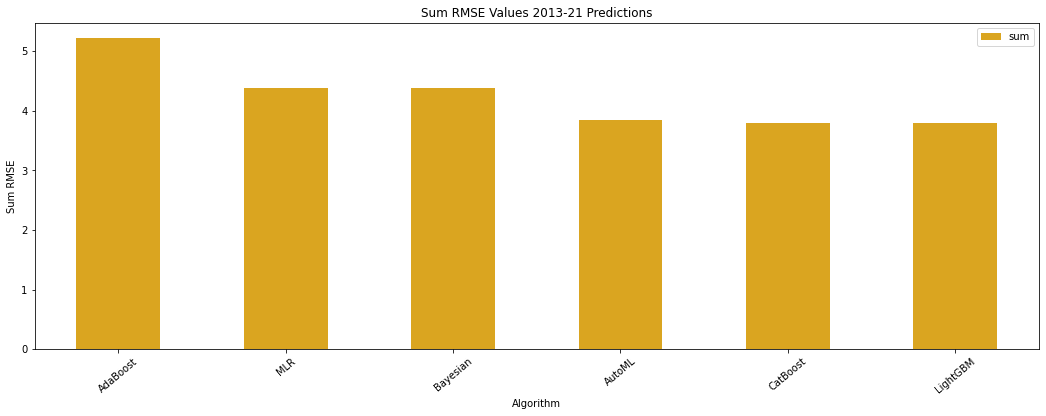

In [462]:
# rmse results
grouped_multiple1 = vis2.groupby(['Algorithm']).agg({'RMSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple1.columns = ['mean','median','max','sum']
grouped_multiple1.reset_index(inplace = True)
distdf = grouped_multiple1.sort_values(by = ['sum'], ascending = False).head(15)
distdf.plot.bar(x = 'Algorithm', y = 'sum', rot = 40, figsize=(18, 6), color='goldenrod', xlabel='Algorithm', ylabel='Sum RMSE', title='Sum RMSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Sum MEDAE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Sum MEDAE'>

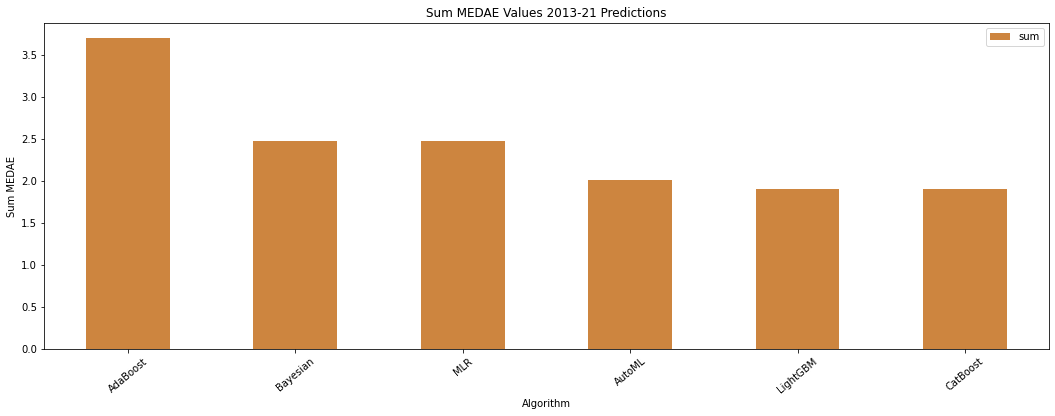

In [463]:
# median results
grouped_multiple2 = vis2.groupby(['Algorithm']).agg({'MEDAE': ['mean', 'median', 'max', 'sum']})
grouped_multiple2.columns = ['mean','median','max','sum']
grouped_multiple2.reset_index(inplace = True)
distdf = grouped_multiple2.sort_values(by = ['sum'], ascending = False).head(15)
distdf.plot.bar(x = 'Algorithm', y = 'sum', rot = 40, figsize=(18, 6), color='peru', xlabel='Algorithm', ylabel='Sum MEDAE', title='Sum MEDAE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean Accuracy Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Average Accuracy'>

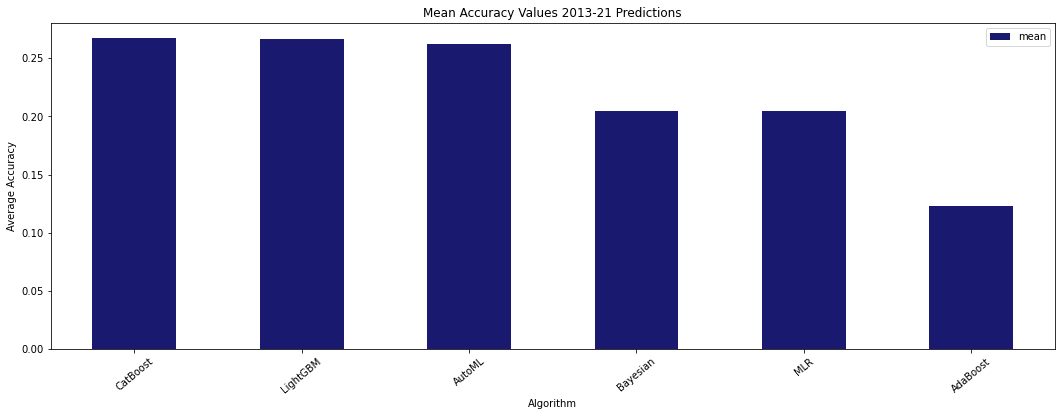

In [464]:
grouped_multiple3 = vis2.groupby(['Algorithm']).agg({'Accuracy': ['mean', 'median', 'max', 'sum']})
grouped_multiple3.columns = ['mean','median','max','sum']
grouped_multiple3.reset_index(inplace = True)
distdf = grouped_multiple3.sort_values(by = ['mean'], ascending = False).head(15)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='midnightblue', xlabel='Algorithm', ylabel='Average Accuracy', title='Mean Accuracy Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Sum MSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Sum MSE'>

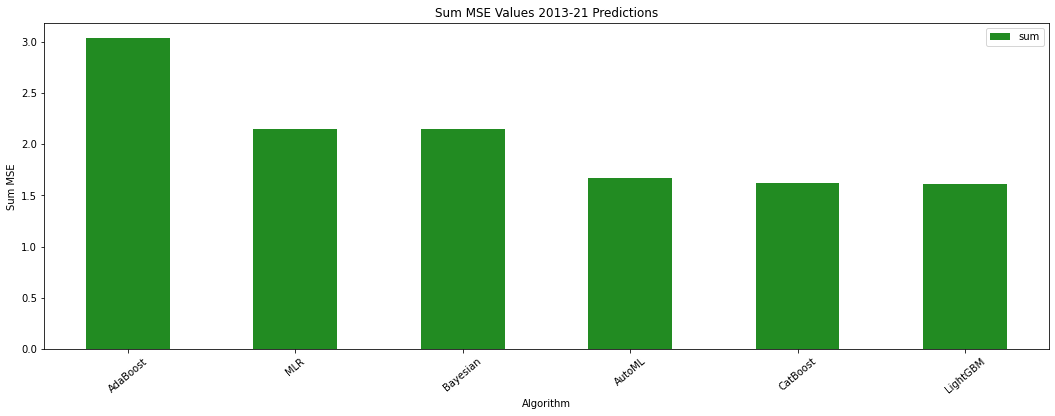

In [465]:
# mse results
grouped_multiple4 = vis2.groupby(['Algorithm']).agg({'MSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple4.columns = ['mean','median','max','sum']
grouped_multiple4.reset_index(inplace = True)
distdf = grouped_multiple4.sort_values(by = ['sum'], ascending = False).head(15)
distdf.plot.bar(x = 'Algorithm', y = 'sum', rot = 40, figsize=(18, 6), color='forestgreen', xlabel='Algorithm', ylabel='Sum MSE', title='Sum MSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MAPE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MAPE'>

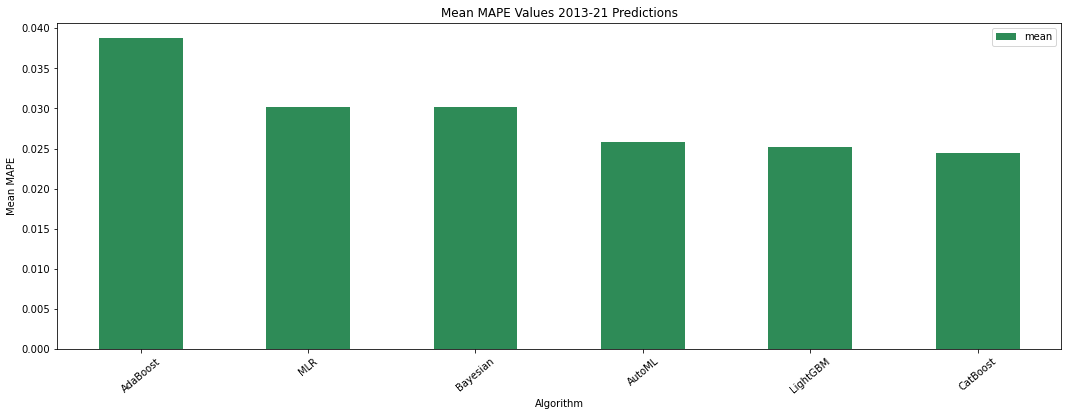

In [466]:
# mape results
grouped_multiple5 = vis2.groupby(['Algorithm']).agg({'MAPE': ['mean', 'median', 'max', 'sum']})
grouped_multiple5.columns = ['mean','median','max','sum']
grouped_multiple5.reset_index(inplace = True)
distdf = grouped_multiple5.sort_values(by = ['mean'], ascending = False).head(15)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='seagreen', xlabel='Algorithm', ylabel='Mean MAPE', title='Mean MAPE Values 2013-21 Predictions')

### Key Takeaways from our 2nd trial of experiments
- AdaBoost is still very poorly performing, even more so than before.
- Accuracy - Our accuracy has definitely improved, with the mean accuracy values now around 25% in contrast to approximately 17.5% without our neighbourhoods. 
- CatBoost is marginally the best performing algorithm now, with the best results in accuracy and MEDAE. LightGBM still has the best results for RMSE and MSE but only very marginally.

In [467]:
grouped_multiple3

,Algorithm,mean,median,max,sum
0,AdaBoost,0.123120,0.125033,0.185995,1.108076
1,AutoML,0.261731,0.267935,0.335329,2.355579
2,Bayesian,0.204548,0.206950,0.272251,1.840936
3,CatBoost,0.266868,0.261780,0.340391,2.401808
4,LightGBM,0.266253,0.258847,0.334184,2.396281
5,MLR,0.204535,0.207063,0.272339,1.840819
